In [1]:
import numpy as np
import math
from numpy.linalg import inv
import matplotlib.pyplot as plt
from numpy.linalg import cholesky, det
from scipy.linalg import solve_triangular
from scipy.optimize import minimize
from scipy.integrate import solve_ivp

import pretty_errors

import gpflow as gpf
from gpflow.utilities import print_summary
from gpflow.utilities import parameter_dict
from gpflow.ci_utils import reduce_in_tests

import tensorflow as tf

gpf.config.set_default_float(np.float64)
gpf.config.set_default_summary_fmt("notebook")
np.random.seed(0)

MAXITER = reduce_in_tests(5000)


In [2]:
## The idea is that we simulate from a lotka volterra model with three species. This model has three growth rates, mu, plus an interaction matrix, M
## We then fit Gaussian processes to the time courses and use model selection to determine the best combination of kernels and mean functions to model the data
## What we ultimately want to know is how the original parameters of the LV model correspond to the best fitting GPs
## This will enable us to work out what information is contained in the GPs

(3, 31)


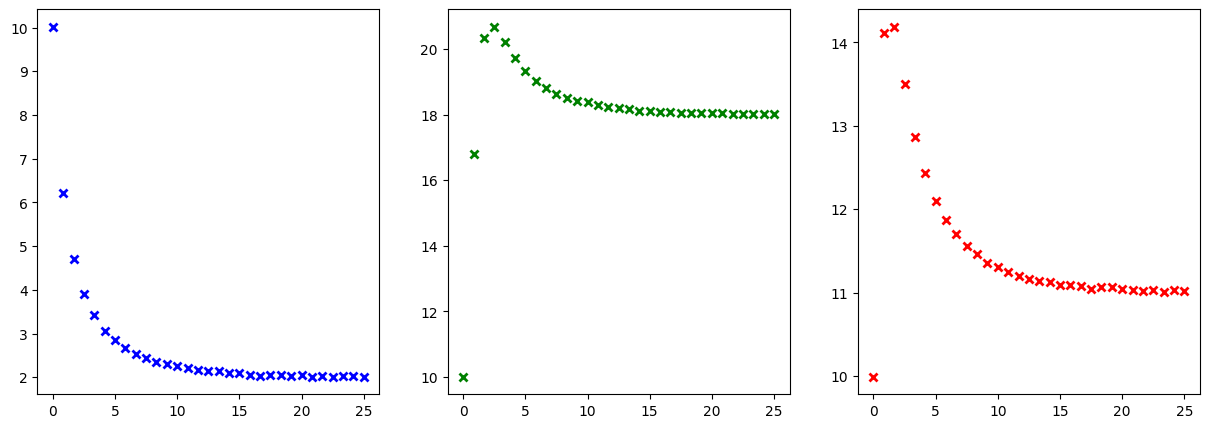

In [2]:
# This function is the Lotka-Volterra predator-prey model
# It takes two arguments: t, the time, and y, a vector of the current population sizes
# It returns a list of the time derivatives of the populations, in the same order as the input

def lotka_volterra(t, y):
    mu = [0.2, 0.7, 0.9]
    M = np.array([[-0.1, 0.0, 0.0], [0.0,-0.1, 0.1], [0.1, 0.0, -0.1]])

    y1 = y[0]
    y2 = y[1]
    y3 = y[2]
    
    dy1 = y1*mu[0] + y1*( M[0,0]*y1 + M[0,1]*y2 + M[0,2]*y3 )
    dy2 = y2*mu[1] + y2*( M[1,0]*y1 + M[1,1]*y2 + M[1,2]*y3 )
    dy3 = y3*mu[2] + y3*( M[2,0]*y1 + M[2,1]*y2 + M[2,2]*y3 ) 
    
    return [dy1, dy2, dy3]

def simulate(y0, t):
  return solve_ivp(fun=lotka_volterra, t_span=[min(t), max(t)], y0=y0, t_eval=t, method='LSODA')

nps = 31
t = np.linspace(0, 25, nps)
y0 = [10.0, 10.0, 10.0]
sol = simulate(y0, t)

# sample data points
# s_idx = np.random.choice(len(t), size = 101, replace=False)
# s_idx.sort()
s_idx = np.arange(nps)
ts = sol.t[s_idx]
ys = sol.y[:,s_idx]

# add noise to growth data
y_hat = np.maximum(ys + np.random.normal(scale=0.01, size=ys.shape), 0)

print(y_hat.shape)

fig, ax = plt.subplots(figsize=(15,5),ncols=3,nrows=1)
ax[0].plot(ts, y_hat[0,:], "bx", mew=2);
ax[1].plot(ts, y_hat[1,:], "gx", mew=2);
ax[2].plot(ts, y_hat[2,:], "rx", mew=2);


In [3]:
# Fit whole system using various multi-ouput kernels and VGP


def plot_gp_d(x, mu, var, color, label, ax):
    ax.plot(x, mu, color=color, lw=2, label=label)
    ax.fill_between(
        x[:, 0],
        (mu - 2 * np.sqrt(var))[:, 0],
        (mu + 2 * np.sqrt(var))[:, 0],
        color=color,
        alpha=0.4,
    )
    ax.set_xlabel("X")
    ax.set_ylabel("y")

def plot_model(m, X, P, L, K_L, M_F, BIC):
    fig, ax = plt.subplots(figsize=(15,5),ncols=3,nrows=1)
    ax[0].plot(X[:,0], Y[:,0], "bx", mew=2);
    ax[1].plot(X[:,0], Y[:,1], "gx", mew=2);
    ax[2].plot(X[:,0], Y[:,2], "rx", mew=2);

    # just use the GP to predict at same timepoints
    mu1, var1 = m.predict_y(np.hstack((X, np.zeros_like(X)) ))
    plot_gp_d(X, mu1, var1, "b", "Y1", ax[0])

    mu2, var2 = m.predict_y(np.hstack((X, np.ones_like(X)) ))
    plot_gp_d(X, mu2, var2, "g", "Y2", ax[1])

    mu3, var3 = m.predict_y(np.hstack((X, 2*np.ones_like(X)) ))
    plot_gp_d(X, mu3, var3, "r", "Y3", ax[2]);

    fig.suptitle('species= ' + str(P) + ', latent_processes= ' +  str(L) + ', kernel= ' + str(K_L.__name__) + ', mean= ' + str(M_F.__class__.__name__) + ', BIC =' + str(BIC))
    
def optimize_model_with_scipy(model):
    optimizer = gpf.optimizers.Scipy()
    res = optimizer.minimize(
        model.training_loss_closure( (X,Y) ),
        variables=model.trainable_variables,
        method="l-bfgs-b",
        #options={"disp": 50, "maxiter": MAXITER},
        options={"maxiter": MAXITER},
    )
    return res

def count_params(m):
    p_dict = parameter_dict(m)
    p_count = 0
    for val in p_dict.values():
        #print(val.shape)
        if len(val.shape) == 0:
            p_count = p_count + 1
        else:
            p_count = p_count + math.prod( val.shape )

    return p_count

## This is for model selection: the lower the BIC the better the model
def get_BIC(m, F, n):
    # Assumes F = -lnL
    k = count_params(m)
    return k*np.log(n) + 2*F


In [4]:
## Here do coregionalization to estimate f(x) = W g(x)
## https://gpflow.github.io/GPflow/2.8.0/notebooks/advanced/multioutput.html
## https://gpflow.github.io/GPflow/develop/notebooks/getting_started/mean_functions.html
## https://towardsdatascience.com/sparse-and-variational-gaussian-process-what-to-do-when-data-is-large-2d3959f430e7
## https://gpflow.readthedocs.io/en/v1.5.1-docs/notebooks/advanced/coregionalisation.html
## https://gpflow.github.io/GPflow/2.4.0/notebooks/advanced/coregionalisation.html
# This uses VGP

X = ts.reshape(-1,1)
Y = y_hat.T

print(X.shape)
print(Y.shape)

# Augment the input with ones or zeros to indicate the required output dimension
X_aug = np.vstack(
    (np.hstack((X, np.zeros_like(X))), 
     np.hstack((X, np.ones_like(X))),
     np.hstack((X, 2*np.ones_like(X)))
    )
)

# Augment the Y data with ones or zeros that specify a likelihood from the list of likelihoods
Y1 = Y[:,0].reshape(-1,1)
Y2 = Y[:,1].reshape(-1,1)
Y3 = Y[:,2].reshape(-1,1)
                
Y_aug = np.vstack(
    (np.hstack((Y1, np.zeros_like(Y1))), 
     np.hstack((Y2, np.ones_like(Y2))), 
     np.hstack((Y3, 2*np.ones_like(Y3)))
    )
)

#print(X)
#print(X_aug)
#print(Y_aug)

(31, 1)
(31, 3)


30178.233777447625


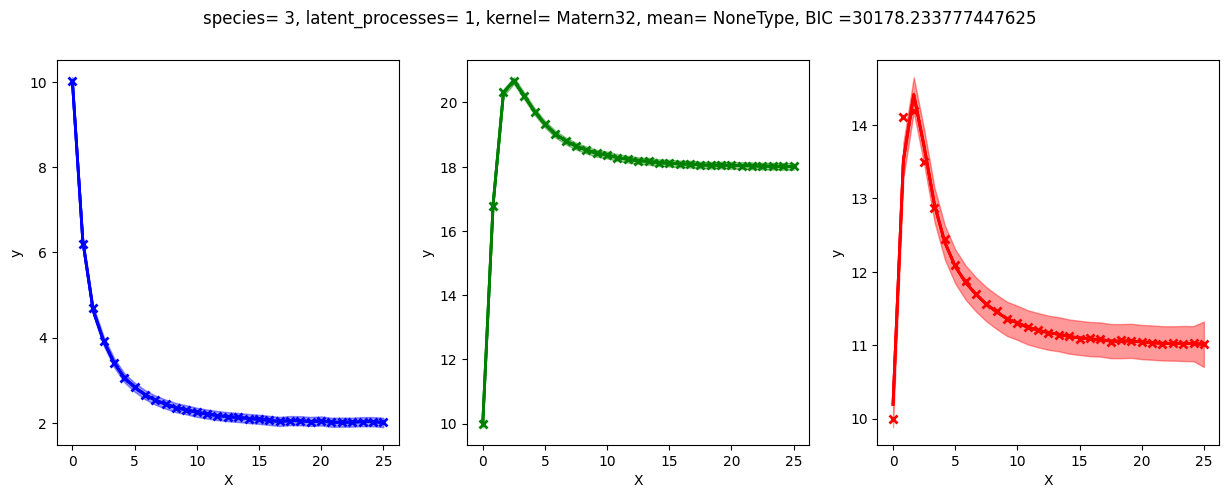

In [5]:
L = 1 # latent processes, g in R^L
P = 3 # observed processes, f in R^P

# Base kernel
k = gpf.kernels.Matern32(active_dims=[0])
#k = gpf.kernels.SquaredExponential(active_dims=[0])

# Coregion kernel
coreg = gpf.kernels.Coregion(
    output_dim=P, 
    rank=L, 
    active_dims=[1]
)

kern = k * coreg

# This likelihood switches between Gaussian noise with different variances for each f_i:
lik = gpf.likelihoods.SwitchedLikelihood(
    [gpf.likelihoods.Gaussian(), gpf.likelihoods.Gaussian(), gpf.likelihoods.Gaussian()]
)

# now build the GP model as normal
m = gpf.models.VGP((X_aug, Y_aug), kernel=kern, likelihood=lik)

# fit the covariance function parameters
maxiter = reduce_in_tests(10000)
res = gpf.optimizers.Scipy().minimize(
        m.training_loss,
        m.trainable_variables,
        options=dict(maxiter=maxiter),
        method="L-BFGS-B",
    )



print_summary(m)
#plot_model(m)
BIC = get_BIC(m,res.fun,X.shape[0])
print(BIC)
plot_model(m,X,P,L,gpf.kernels.Matern32,M_F=None,BIC=BIC)

In [6]:
## Wrap above code into a funtion
# P is the number of outputs (three in this case for the three species)
# L is the number of latent processes
# K_L is the kernel for the latent processes
# M_F is the mean function applied to latent processes

def fit_model(X_aug, Y_aug, P, L, K_L=gpf.kernels.SquaredExponential, M_F=None):
    
    # Base kernel for leatent processes
    #k = gpf.kernels.Matern32(active_dims=[0])
    #k = gpf.kernels.SquaredExponential(active_dims=[0])

    k = K_L(active_dims=[0])
    
    # Coregion kernel
    coreg = gpf.kernels.Coregion(
        output_dim=P, 
        rank=L, 
        active_dims=[1]
    )

    kern = k * coreg

    # This likelihood switches between Gaussian noise with different variances for each f_i:
    lik = gpf.likelihoods.SwitchedLikelihood(
        [gpf.likelihoods.Gaussian() for _ in range(P)]
    )

    # now build the GP model as normal
    m = gpf.models.VGP((X_aug, Y_aug), kernel=kern, likelihood=lik, mean_function=M_F)

    # fit the covariance function parameters
    maxiter = reduce_in_tests(10000)
    res = gpf.optimizers.Scipy().minimize(
        m.training_loss,
        m.trainable_variables,
        options=dict(maxiter=maxiter),
        method="L-BFGS-B",
    )

    print_summary(m)
    BIC = get_BIC(m,res.fun,X.shape[0])
    print("BIC:", BIC)
    plot_model(m,X, P, L, K_L, M_F, BIC)

    return m, BIC



## Try different kernels
#k = gpf.kernels.Matern32(active_dims=[0])
#k = gpf.kernels.SquaredExponential(active_dims=[0])
#k = gpf.kernels.RationalQuadratic(active_dims=[0])
#k = gpf.kernels.Exponential(active_dims=[0])
#k = gpf.kernels.Linear(active_dims=[0])
#k = gpf.kernels.Cosine(active_dims=[0])
#k = gpf.kernels.Periodic(active_dims=[0])
#k = gpf.kernels.Polynomial(active_dims=[0])
#k = gpf.kernels.Matern12(active_dims=[0])
#k = gpf.kernels.Matern52(active_dims=[0])
#k = gpf.kernels.Brownian(active_dims=[0])
#k = gpf.kernels.White(active_dims=[0])
#k = gpf.kernels.Constant(active_dims=[0])
#k = gpf.kernels.Coregion(active_dims=[0])
#k = gpf.kernels.ChangePoints(active_dims=[0])
#k = gpf.kernels.LinearCoregionalization(active_dims=[0])
    

BIC: 30178.233777447625


(<gpflow.models.vgp.VGP object at 0x0000026B0B840130>
name                                    class      transform         prior    trainable    shape        dtype    value
--------------------------------------  ---------  ----------------  -------  -----------  -----------  -------  ----------------------------------------
VGP.kernel.kernels[0].variance          Parameter  Softplus                   True         ()           float64  8.35352
VGP.kernel.kernels[0].lengthscales      Parameter  Softplus                   True         ()           float64  19.86844
VGP.kernel.kernels[1].W                 Parameter  Identity                   True         (3, 1)       float64  [[-4.58565]
 [ 8.64141]
 [ 5.41759]]
VGP.kernel.kernels[1].kappa             Parameter  Softplus                   True         (3,)         float64  [4.49827 4.80225 2.77682]
VGP.likelihood.likelihoods[0].variance  Parameter  Softplus + Shift           True         ()           float64  0.00158
VGP.likelihood.likel

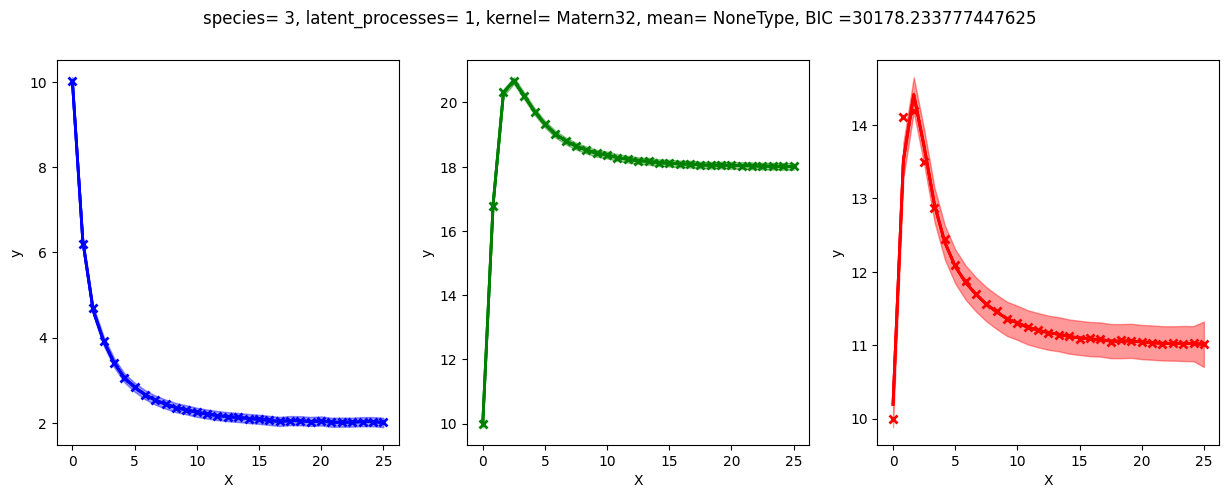

In [30]:
fit_model(X_aug,Y_aug,3,1,gpf.kernels.Matern32)

BIC: 30159.22883253633


(<gpflow.models.vgp.VGP object at 0x0000026B0582AC20>
name                                    class      transform         prior    trainable    shape        dtype    value
--------------------------------------  ---------  ----------------  -------  -----------  -----------  -------  -------------------------------------------
VGP.mean_function.w                     Parameter  Identity                   True         (1, 3)       float64  [[ 9.38712e+00 -4.02740e-01  5.53000e-03]]
VGP.kernel.kernels[0].variance          Parameter  Softplus                   True         ()           float64  4.40948
VGP.kernel.kernels[0].lengthscales      Parameter  Softplus                   True         ()           float64  4.29087
VGP.kernel.kernels[1].W                 Parameter  Identity                   True         (3, 1)       float64  [[-4.14666]
 [ 8.85292]
 [ 4.79001]]
VGP.kernel.kernels[1].kappa             Parameter  Softplus                   True         (3,)         float64  [0.08466 

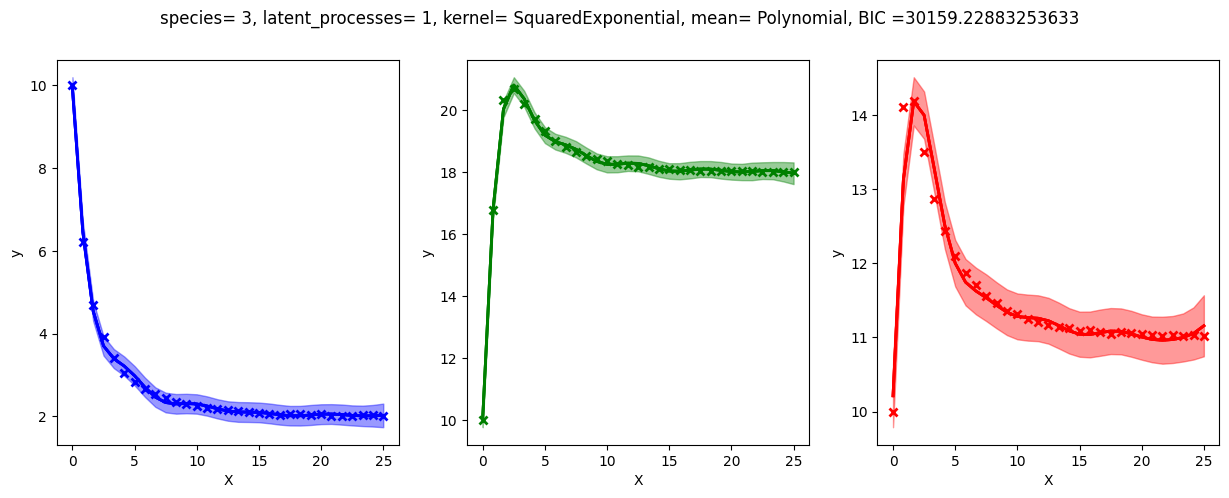

In [31]:
fit_model(X_aug,Y_aug,3,1,gpf.kernels.SquaredExponential, M_F=gpf.functions.Polynomial(2))

BIC: 30184.895998998967


(<gpflow.models.vgp.VGP object at 0x0000026B0B8F4BB0>
name                                    class      transform         prior    trainable    shape        dtype    value
--------------------------------------  ---------  ----------------  -------  -----------  -----------  -------  ------------------------------------------
VGP.mean_function.w                     Parameter  Identity                   True         (1, 3)       float64  [[ 9.33955e+00 -4.03880e-01  5.61000e-03]]
VGP.kernel.kernels[0].variance          Parameter  Softplus                   True         ()           float64  5.75672
VGP.kernel.kernels[0].lengthscales      Parameter  Softplus                   True         ()           float64  4.40326
VGP.kernel.kernels[1].W                 Parameter  Identity                   True         (3, 2)       float64  [[-2.57023, -2.57023...
VGP.kernel.kernels[1].kappa             Parameter  Softplus                   True         (3,)         float64  [0.09373 0.928   0.1548

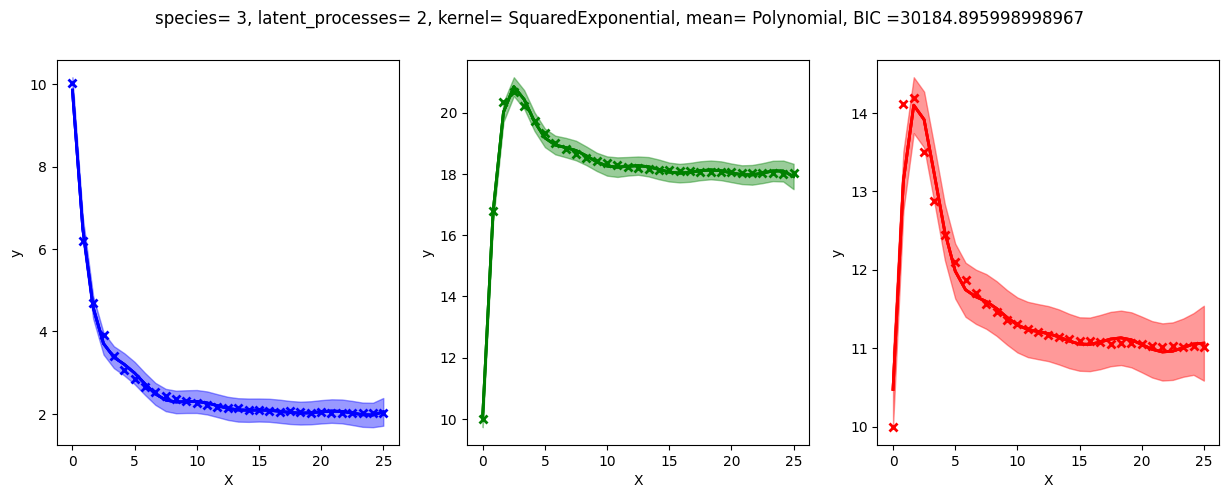

In [32]:
fit_model(X_aug,Y_aug,3,2,gpf.kernels.SquaredExponential, M_F=gpf.functions.Polynomial(2))

BIC: 30534.010618637392


(<gpflow.models.vgp.VGP object at 0x0000026B076D4B80>
name                                    class      transform         prior    trainable    shape        dtype    value
--------------------------------------  ---------  ----------------  -------  -----------  -----------  -------  ---------------------------------
VGP.mean_function.w                     Parameter  Identity                   True         (1, 3)       float64  [[ 4.61277  0.7335  -0.01315]]
VGP.kernel.kernels[0].variance          Parameter  Softplus                   True         ()           float64  3.78979
VGP.kernel.kernels[0].lengthscales      Parameter  Softplus                   True         ()           float64  3.14788
VGP.kernel.kernels[1].W                 Parameter  Identity                   True         (3, 3)       float64  [[-0.26855, -0.26855, -0.26855...
VGP.kernel.kernels[1].kappa             Parameter  Softplus                   True         (3,)         float64  [0.7139  3.00268 1.38842]
VGP.like

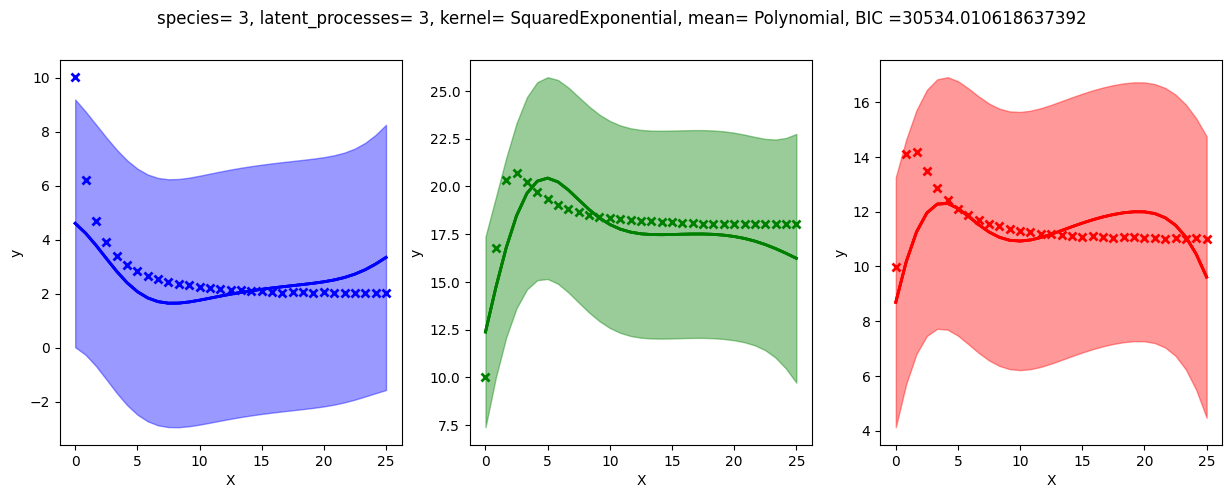

In [33]:
fit_model(X_aug,Y_aug,3,3,gpf.kernels.SquaredExponential, M_F=gpf.functions.Polynomial(2))

BIC: 30254.78691595669


BIC: 30189.80530448943


BIC: 30186.760443489435


BIC: 30159.22883253633


BIC: 30184.895998998967


BIC: 30534.010618637392


(<gpflow.models.vgp.VGP object at 0x0000026B07CC1ED0>
name                                    class      transform         prior    trainable    shape        dtype    value
--------------------------------------  ---------  ----------------  -------  -----------  -----------  -------  ---------------------------------
VGP.mean_function.w                     Parameter  Identity                   True         (1, 3)       float64  [[ 4.61277  0.7335  -0.01315]]
VGP.kernel.kernels[0].variance          Parameter  Softplus                   True         ()           float64  3.78979
VGP.kernel.kernels[0].lengthscales      Parameter  Softplus                   True         ()           float64  3.14788
VGP.kernel.kernels[1].W                 Parameter  Identity                   True         (3, 3)       float64  [[-0.26855, -0.26855, -0.26855...
VGP.kernel.kernels[1].kappa             Parameter  Softplus                   True         (3,)         float64  [0.7139  3.00268 1.38842]
VGP.like

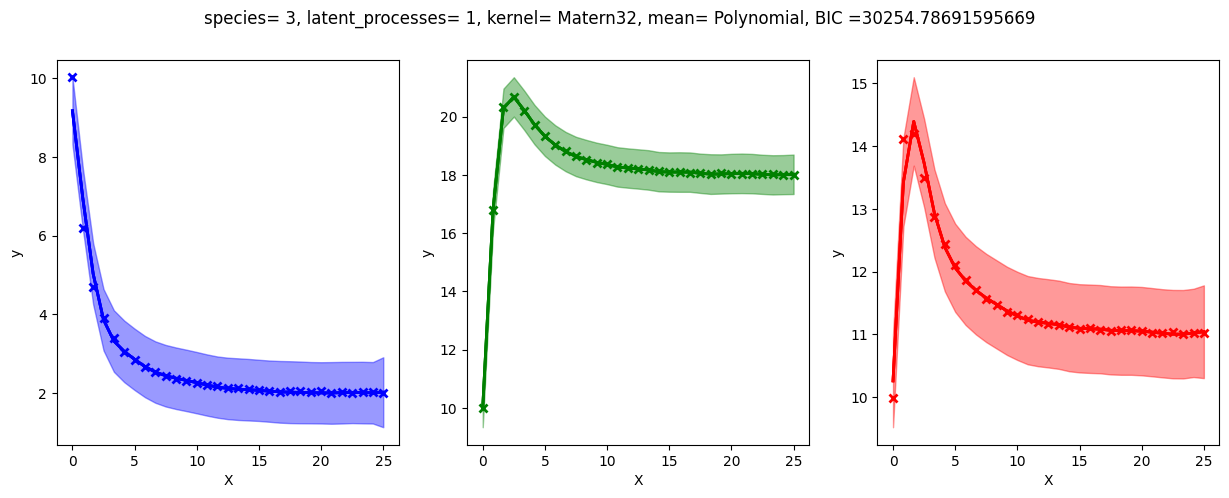

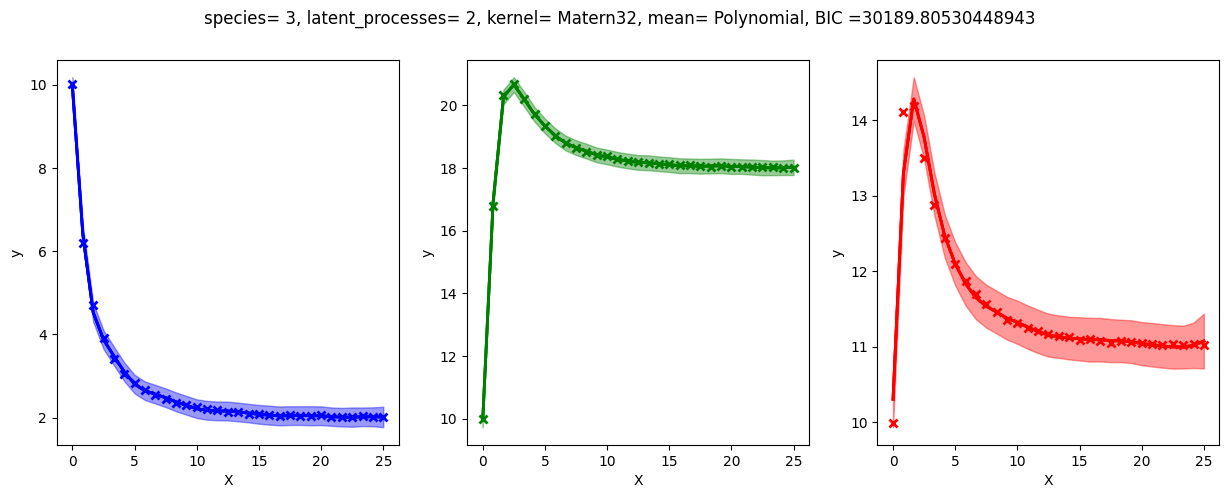

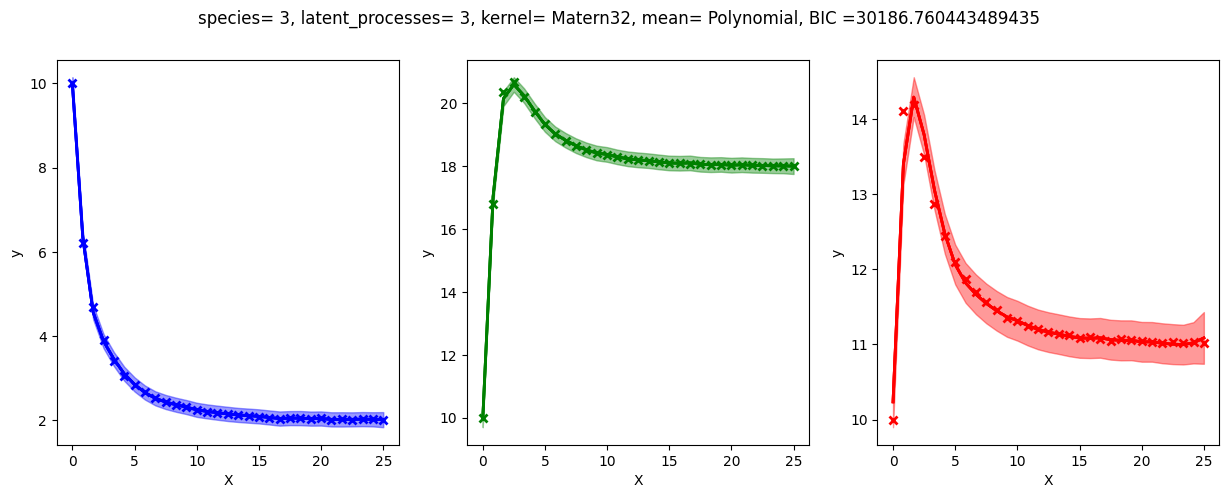

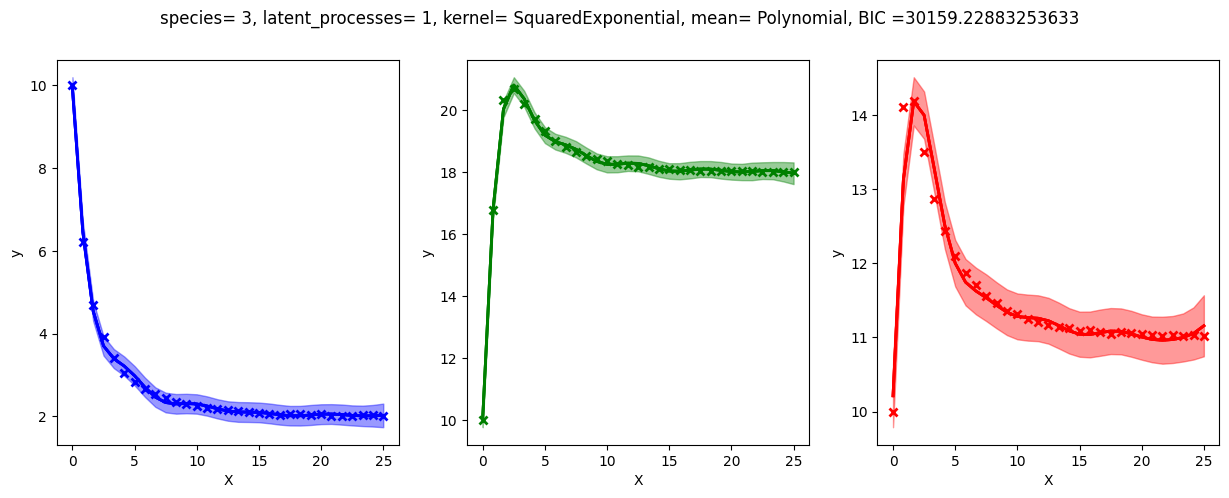

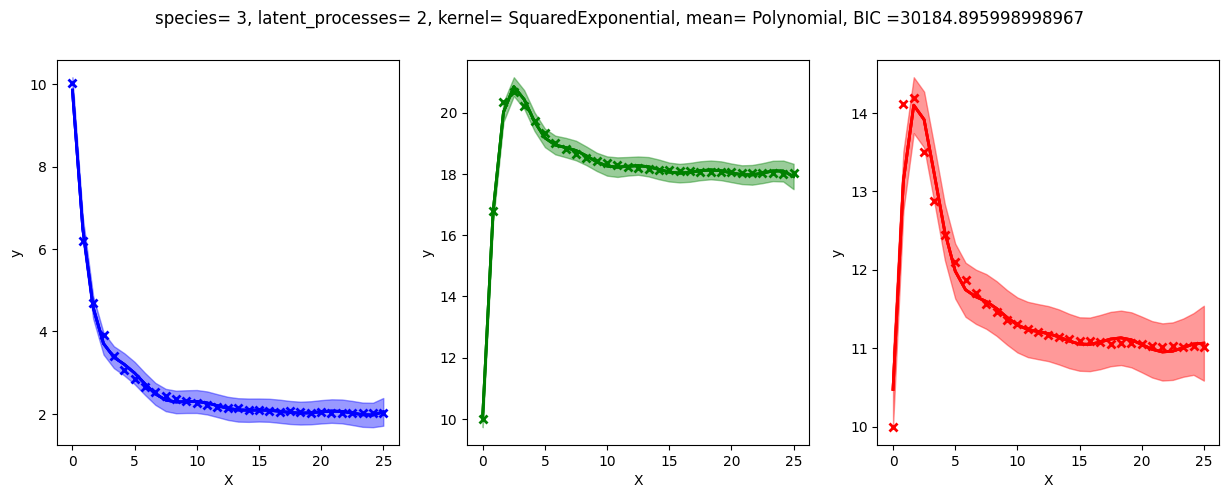

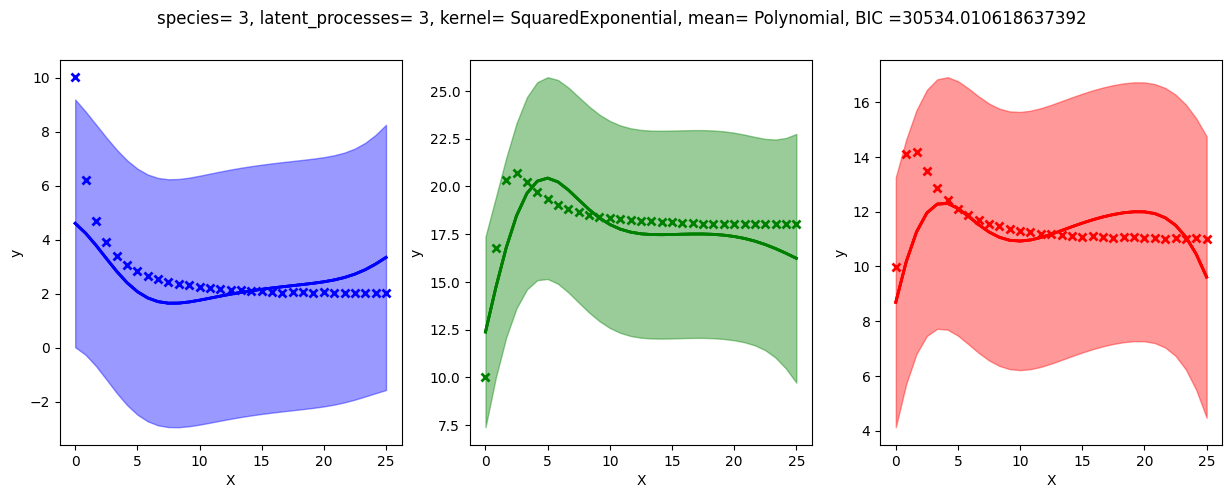

In [34]:
# Try different numbers of latent processes, L, with the same kernel, K_L = matern32 and mean function, M_F = polynomial
fit_model(X_aug,Y_aug,3,1,gpf.kernels.Matern32, M_F=gpf.functions.Polynomial(2))
fit_model(X_aug,Y_aug,3,2,gpf.kernels.Matern32, M_F=gpf.functions.Polynomial(2))
fit_model(X_aug,Y_aug,3,3,gpf.kernels.Matern32, M_F=gpf.functions.Polynomial(2))

# Try different numbers of latent processes, L, with the same kernel, K_L = squared exponential and mean function, M_F = polynomial
fit_model(X_aug,Y_aug,3,1,gpf.kernels.SquaredExponential, M_F=gpf.functions.Polynomial(2))
fit_model(X_aug,Y_aug,3,2,gpf.kernels.SquaredExponential, M_F=gpf.functions.Polynomial(2))
fit_model(X_aug,Y_aug,3,3,gpf.kernels.SquaredExponential, M_F=gpf.functions.Polynomial(2))


In [ ]:
# Try different mean functions, kernels, and number of latent processes and see which one fits the data best using BIC as a metric for model selection (lower is better) 

#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.SquaredExponential, M_F=gpf.functions.Polynomial(2))
if BIC < best_BIC:
    best_model = m
    best_BIC = BIC
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=2, K_L=gpf.kernels.SquaredExponential, M_F=gpf.functions.Polynomial(2))
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=3, K_L=gpf.kernels.SquaredExponential, M_F=gpf.functions.Polynomial(2))
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=4, K_L=gpf.kernels.SquaredExponential, M_F=gpf.functions.Polynomial(2))
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=5, K_L=gpf.kernels.SquaredExponential, M_F=gpf.functions.Polynomial(2))

#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.Matern32, M_F=gpf.functions.Polynomial(2))
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=2, K_L=gpf.kernels.Matern32, M_F=gpf.functions.Polynomial(2))
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=3, K_L=gpf.kernels.Matern32, M_F=gpf.functions.Polynomial(2))
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=4, K_L=gpf.kernels.Matern32, M_F=gpf.functions.Polynomial(2))
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=5, K_L=gpf.kernels.Matern32, M_F=gpf.functions.Polynomial(2))

#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.RationalQuadratic, M_F=gpf.functions.Polynomial(2))

#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.SquaredExponential, M_F=gpf.functions.Constant(0.5))
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.SquaredExponential, M_F=gpf.functions.Constant(1))
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.SquaredExponential, M_F=gpf.functions.Constant(1.5))

#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.Matern32, M_F=gpf.functions.Constant(0.5))
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.Matern32, M_F=gpf.functions.Constant(1))
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.Matern32, M_F=gpf.functions.Constant(1.5))

#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.RationalQuadratic, M_F=gpf.functions.Constant(0.5))
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.RationalQuadratic, M_F=gpf.functions.Constant(1))
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.RationalQuadratic, M_F=gpf.functions.Constant(1.5))

#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.SquaredExponential, M_F=gpf.functions.Linear(0.5))
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.SquaredExponential, M_F=gpf.functions.Linear(1))
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.SquaredExponential, M_F=gpf.functions.Linear(1.5))

#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.Matern32, M_F=gpf.functions.Linear(0.5))
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.Matern32, M_F=gpf.functions.Linear(1))
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.Matern32, M_F=gpf.functions.Linear(1.5))





In [ ]:
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.SquaredExponential, M_F=None)
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.Matern32, M_F=None)
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.RationalQuadratic, M_F=None)
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.Exponential, M_F=None)
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.Linear, M_F=None)
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.Cosine, M_F=None)
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.Periodic, M_F=None)
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.Polynomial, M_F=None)
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.Matern12, M_F=None)
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.Matern52, M_F=None)
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.Brownian, M_F=None)
#m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gpf.kernels.White, M_F=None)

BIC: 30157.242397659647


BIC: 30159.22883253633


BIC: 30178.233777447625


BIC: 30254.78691595669


BIC: 30158.411832480728


BIC: 30179.125843285918


BIC: 30251.845354504185


BIC: 30209.820010527183


BIC: 30642.15070886576


BIC: 30500.021685924366


BIC: 30375.891923922536


BIC: 30387.14554623436


BIC: 30167.80664212038


BIC: 30184.895998998967


BIC: 30193.779025850487


BIC: 30189.80530448943


BIC: 30162.389124942045


BIC: 30187.496090444445


BIC: 30267.200361055722


BIC: 30235.03482130546


BIC: 30652.4499299197


C:\Users\User\AppData\Local\Temp\ipykernel_28068\2928095282.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(15,5),ncols=3,nrows=1)


BIC: 30516.658061491933


BIC: 30386.19183656044


BIC: 30347.87718526871


BIC: 30177.42522151268


BIC: 30534.010618637392


BIC: 30204.005559103665


BIC: 30186.760443489435


BIC: 30173.796879670037


BIC: 30363.510006224442


BIC: 30283.25914920739


BIC: 30231.991153217037


BIC: 30662.753064606397


BIC: 30527.536572600646


BIC: 30396.496897471006


BIC: 30605.389973328332


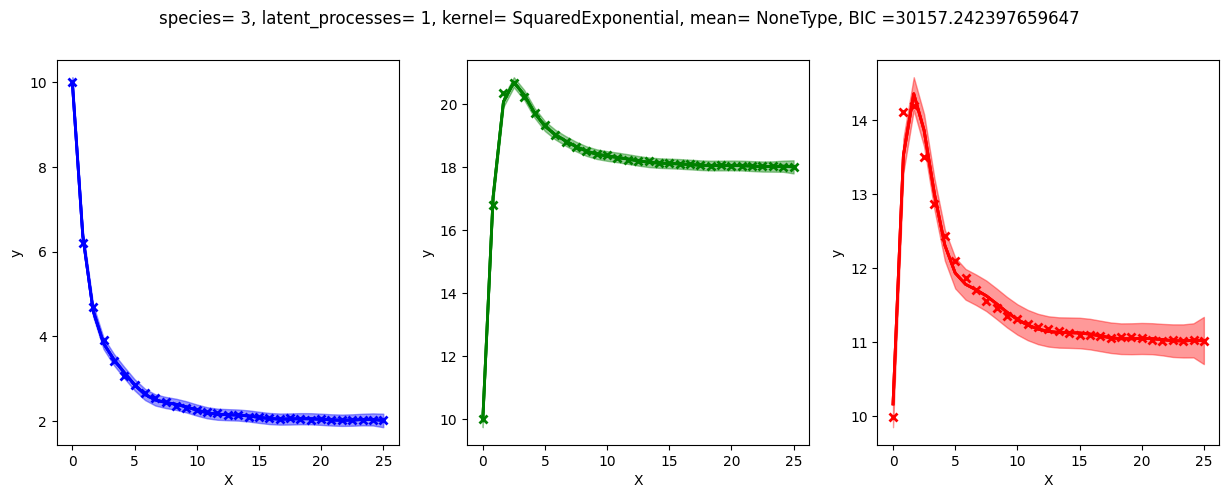

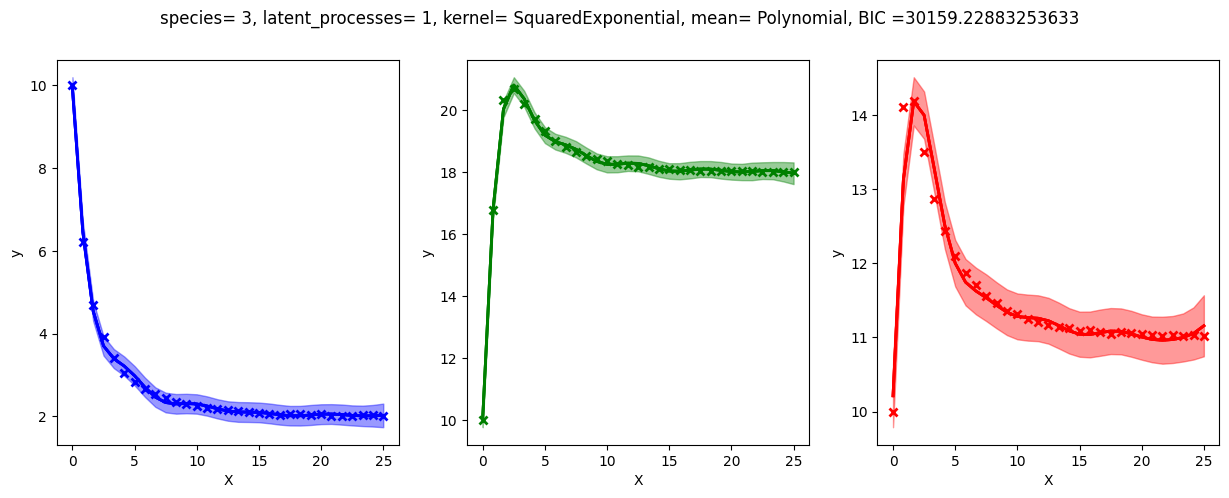

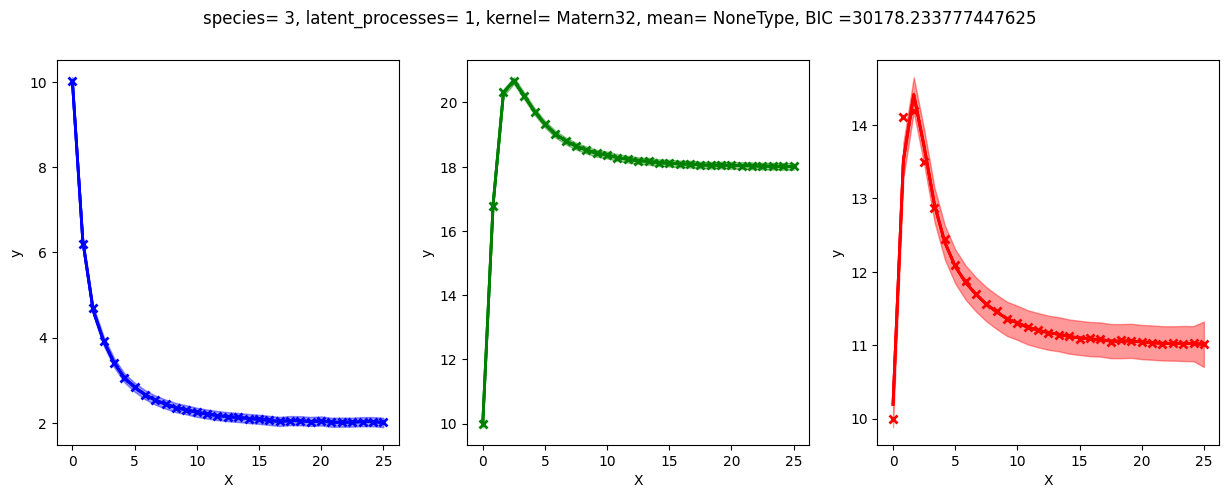

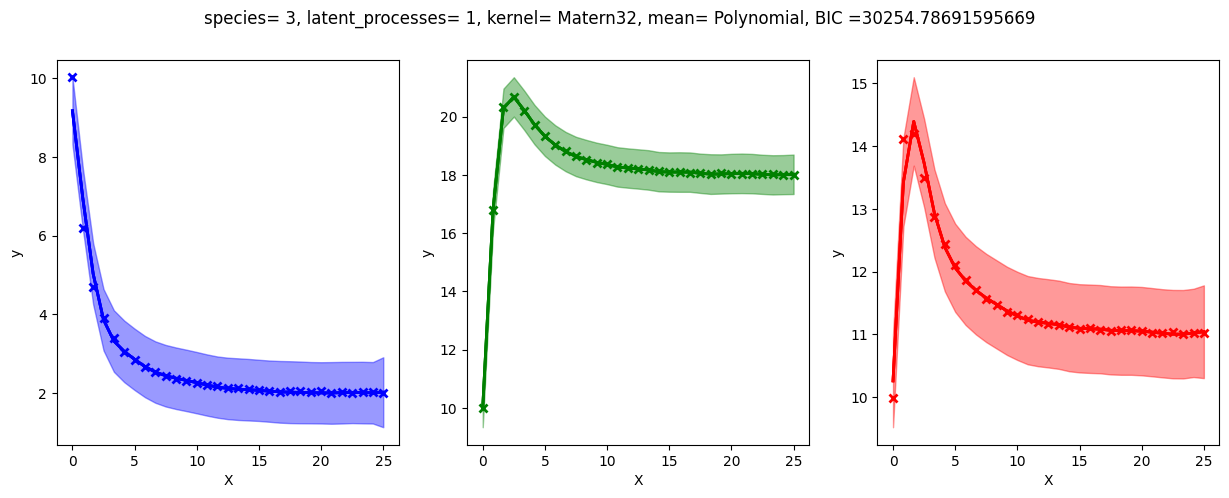

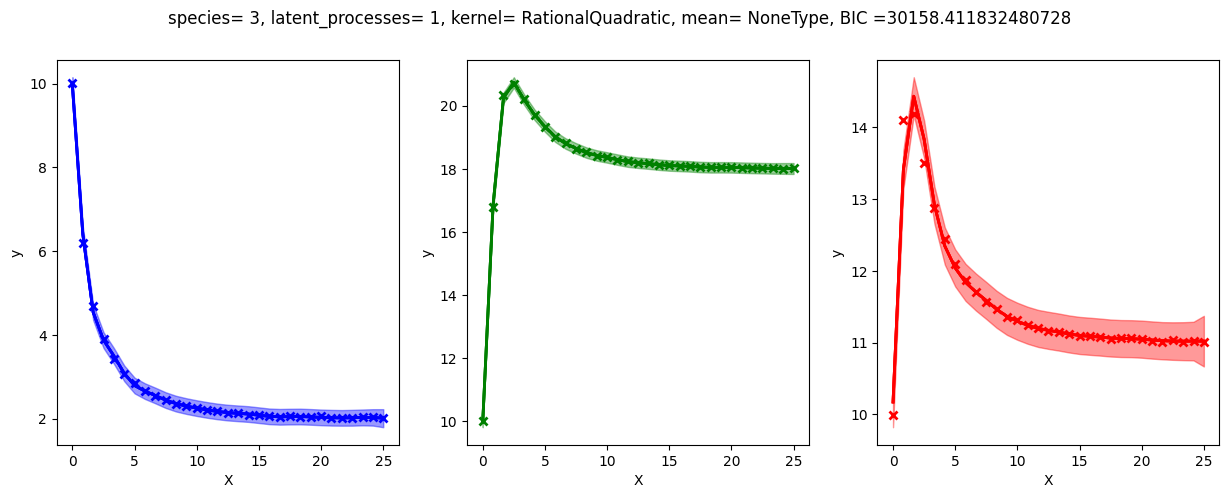

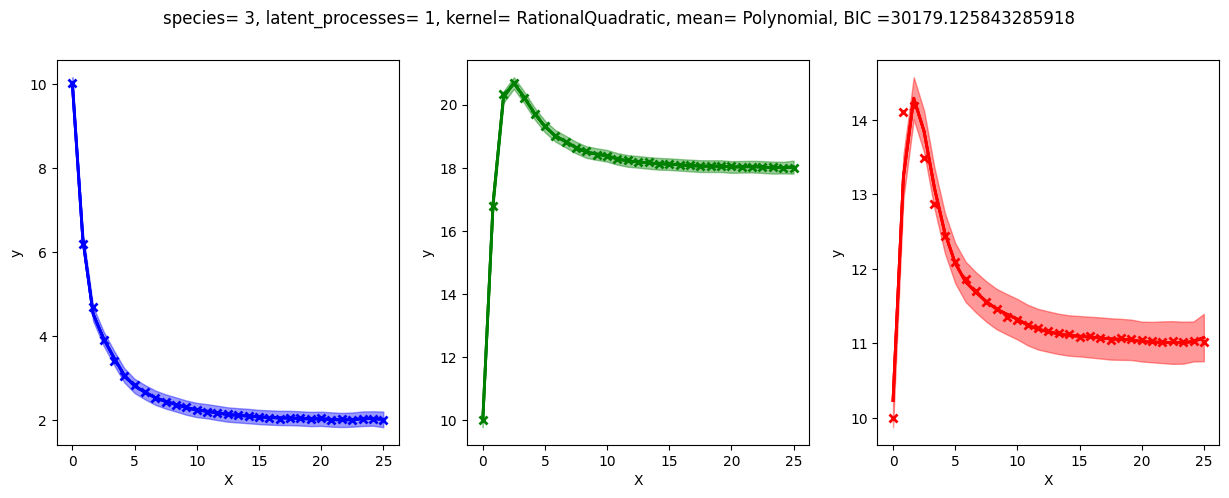

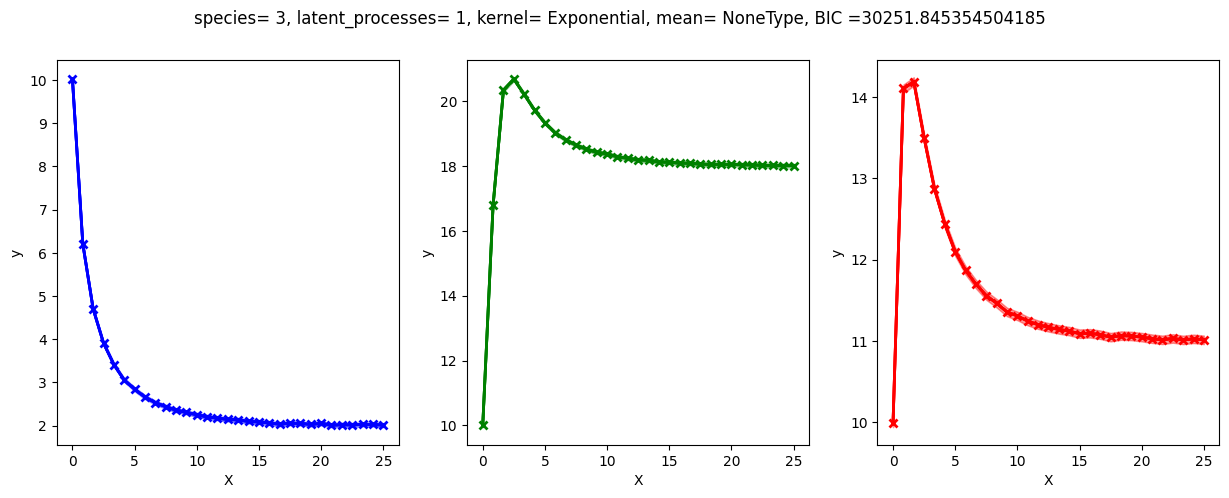

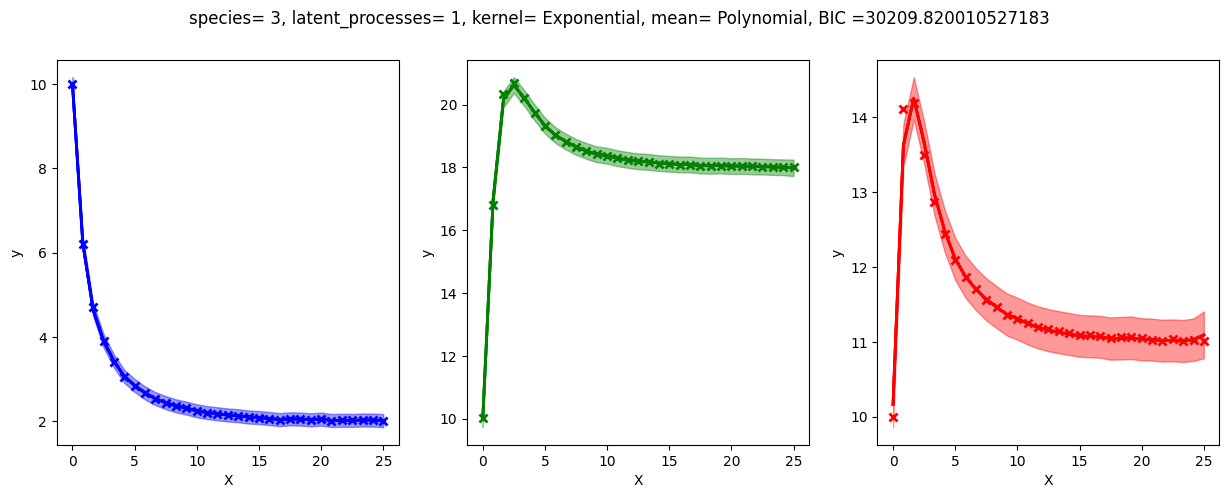

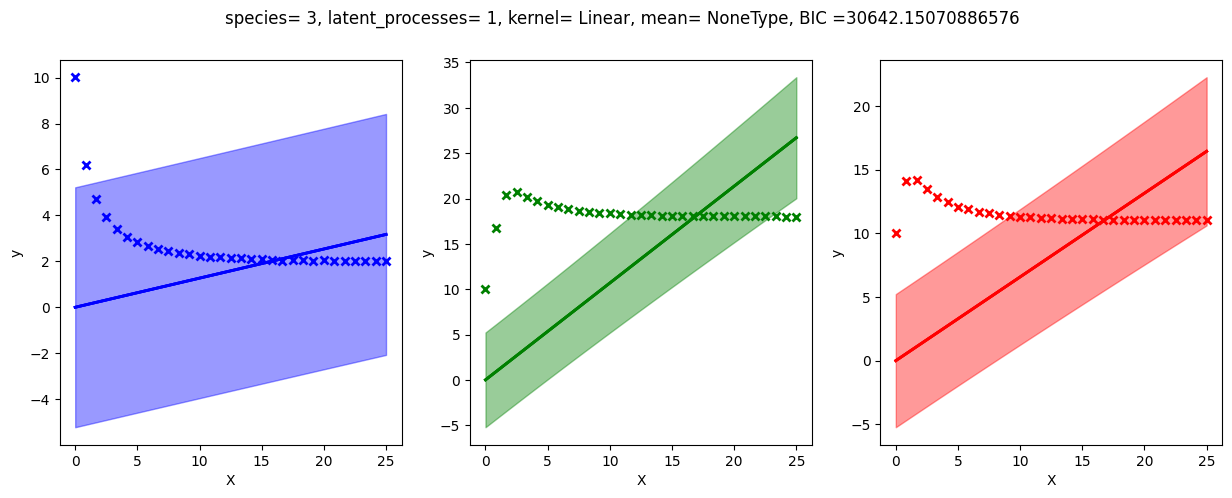

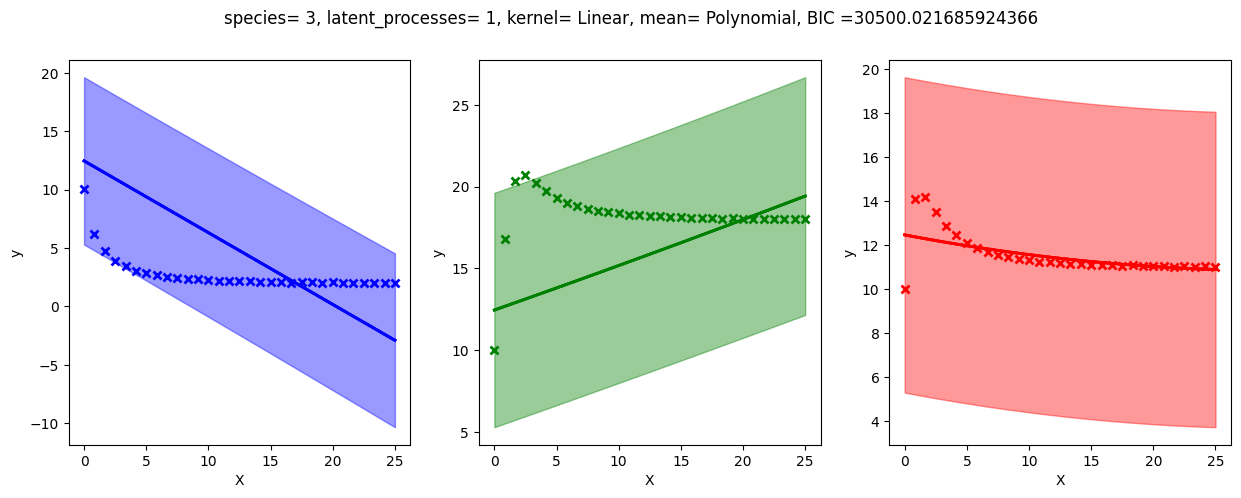

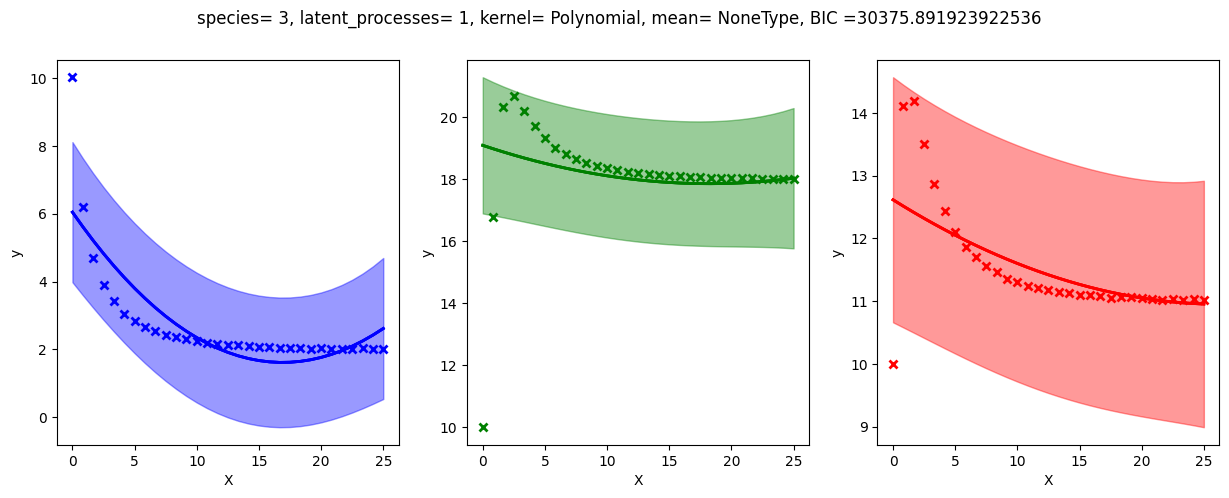

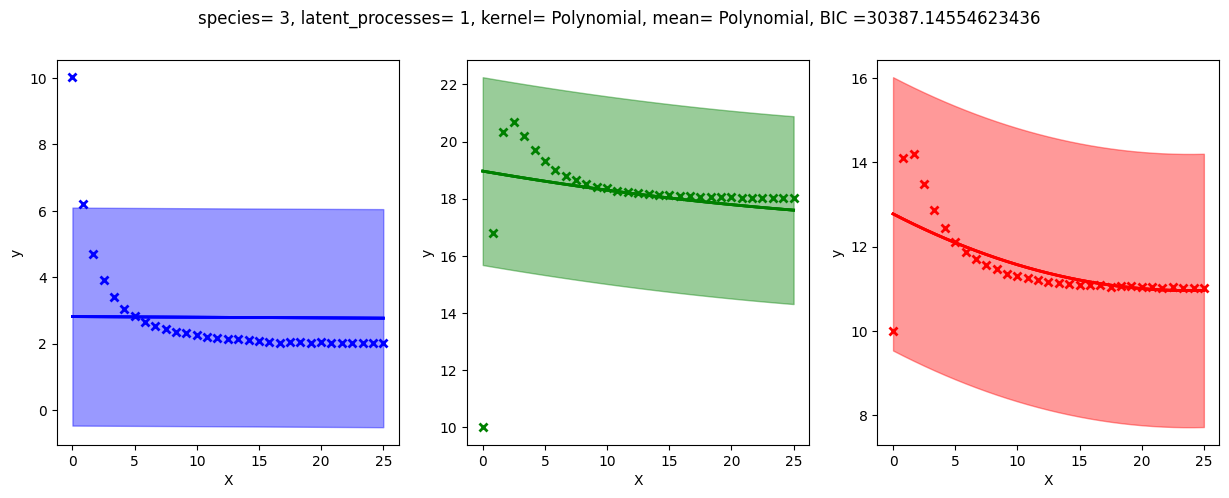

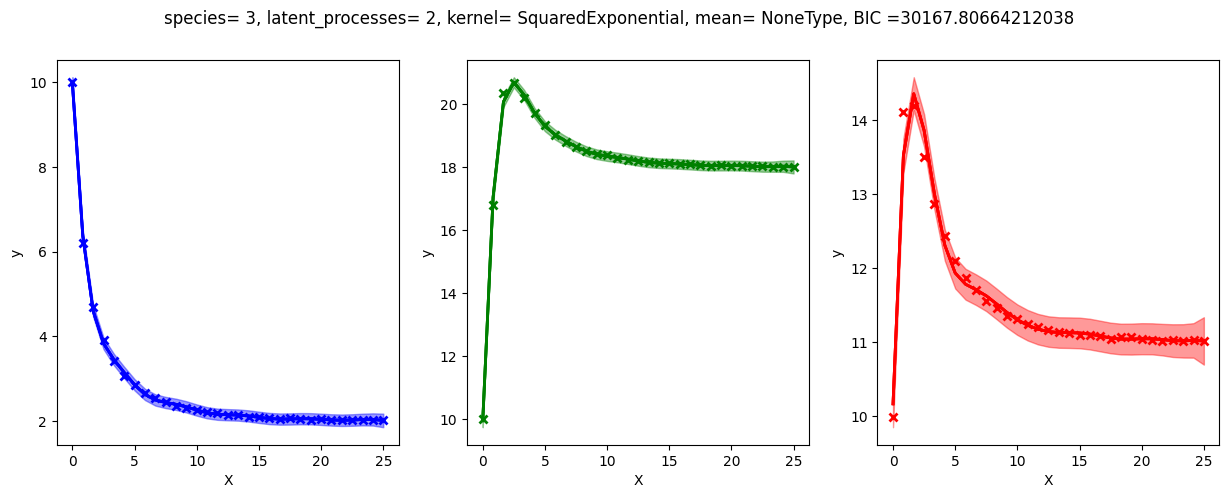

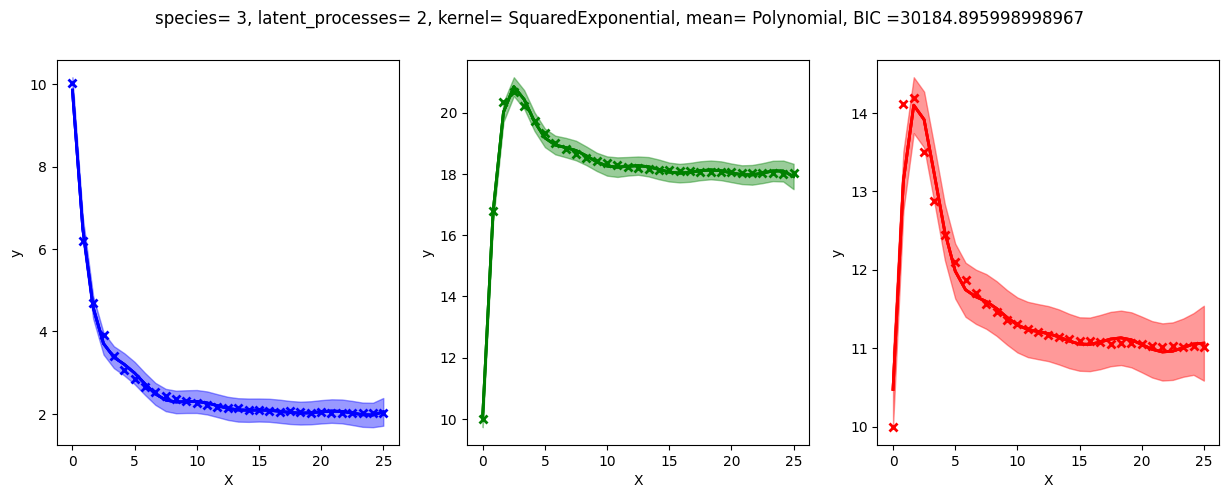

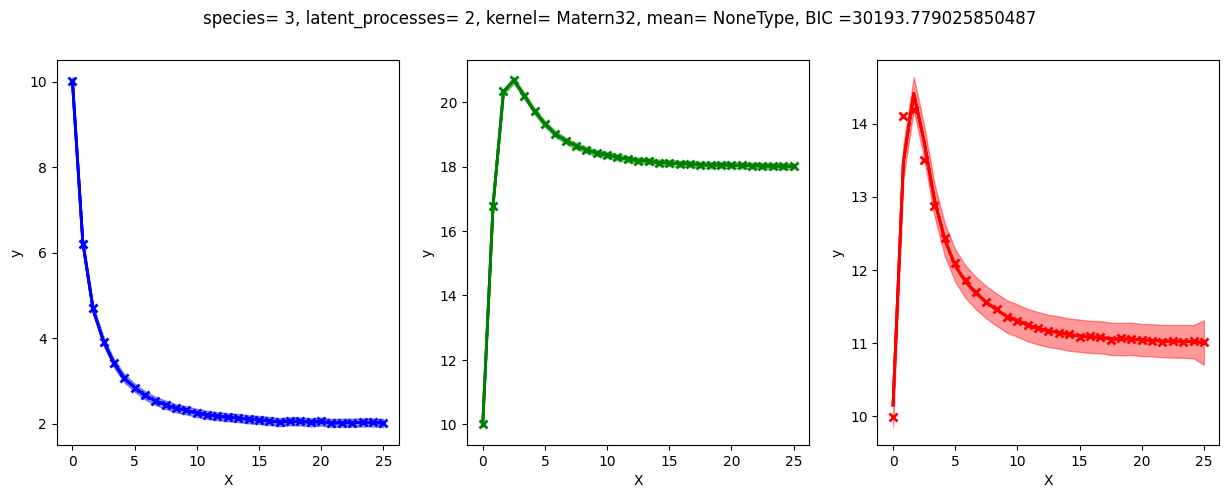

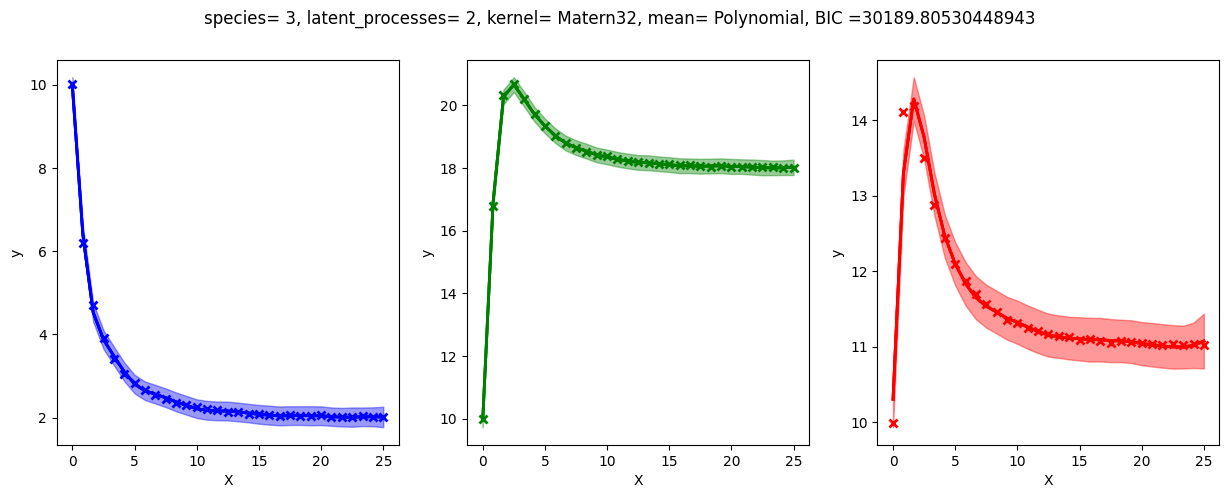

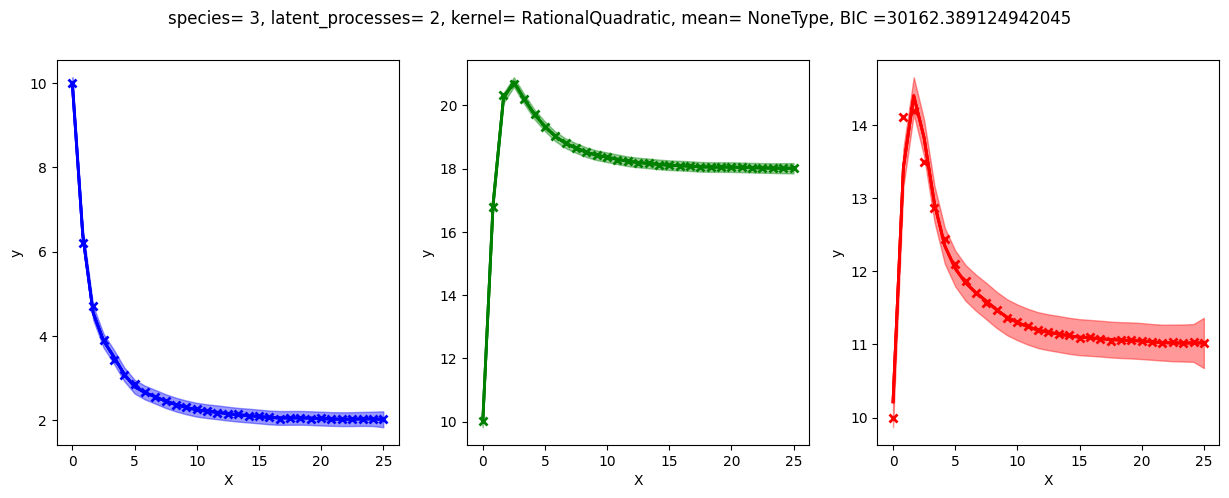

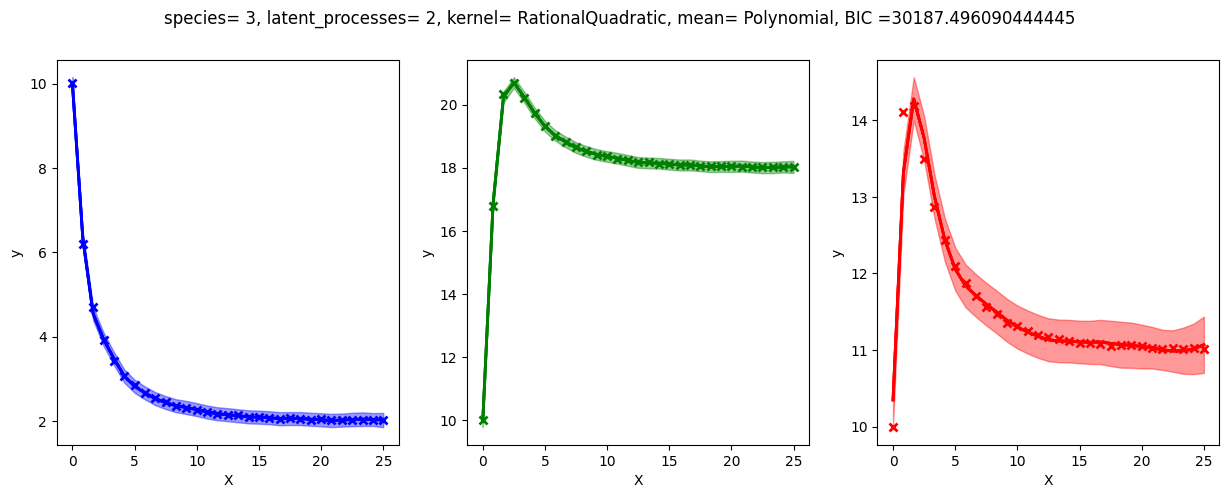

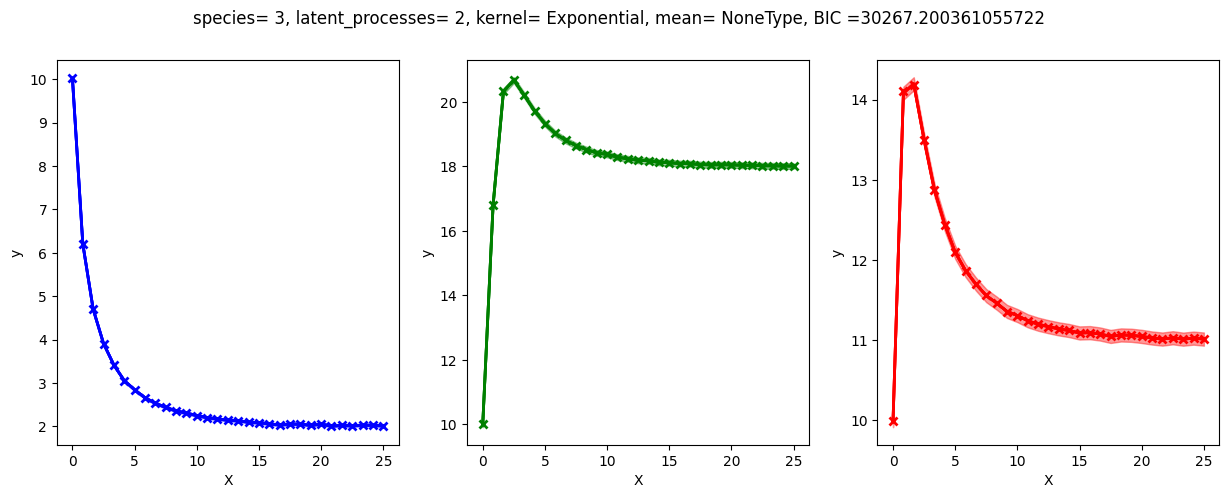

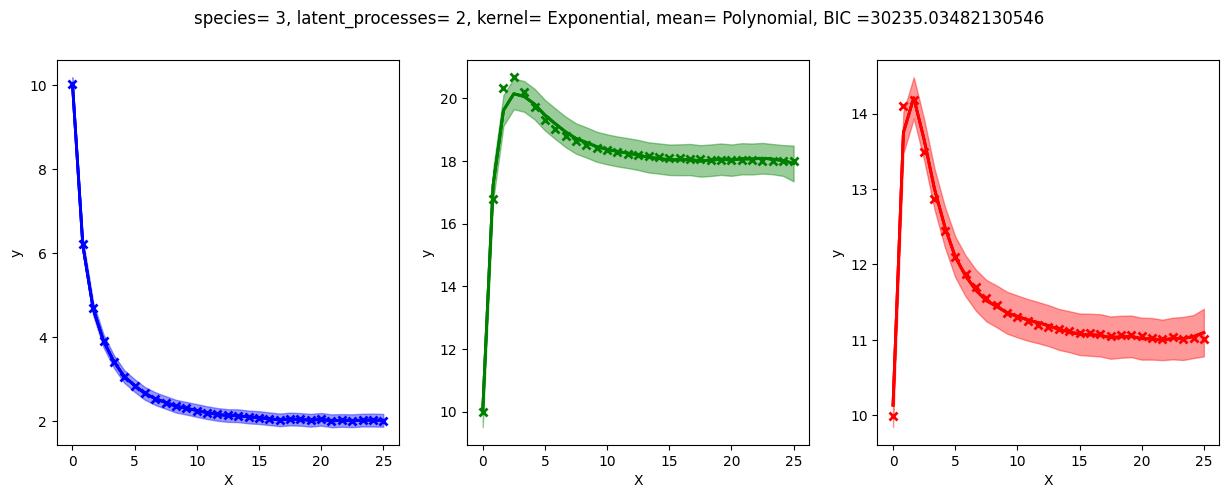

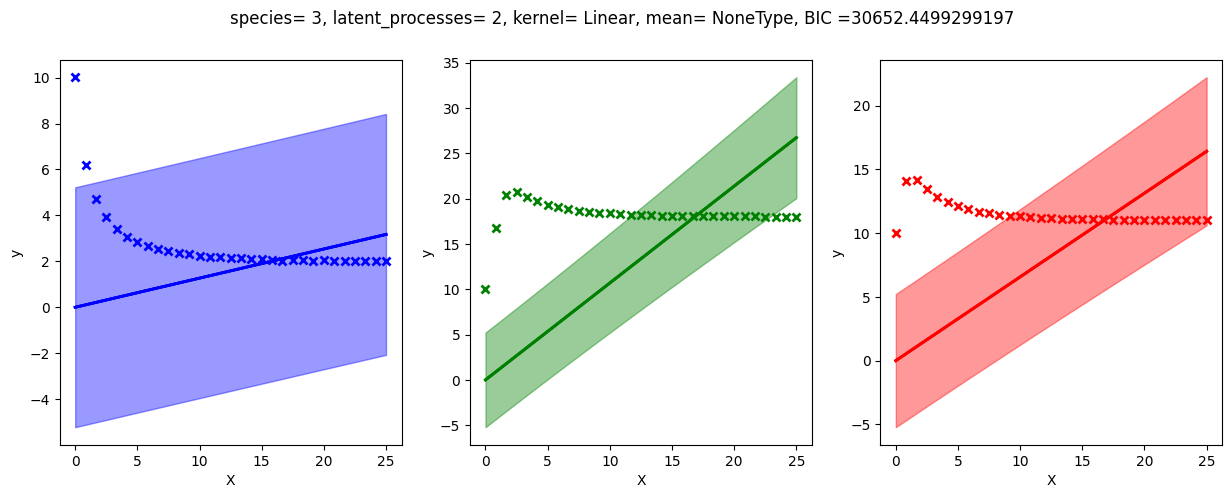

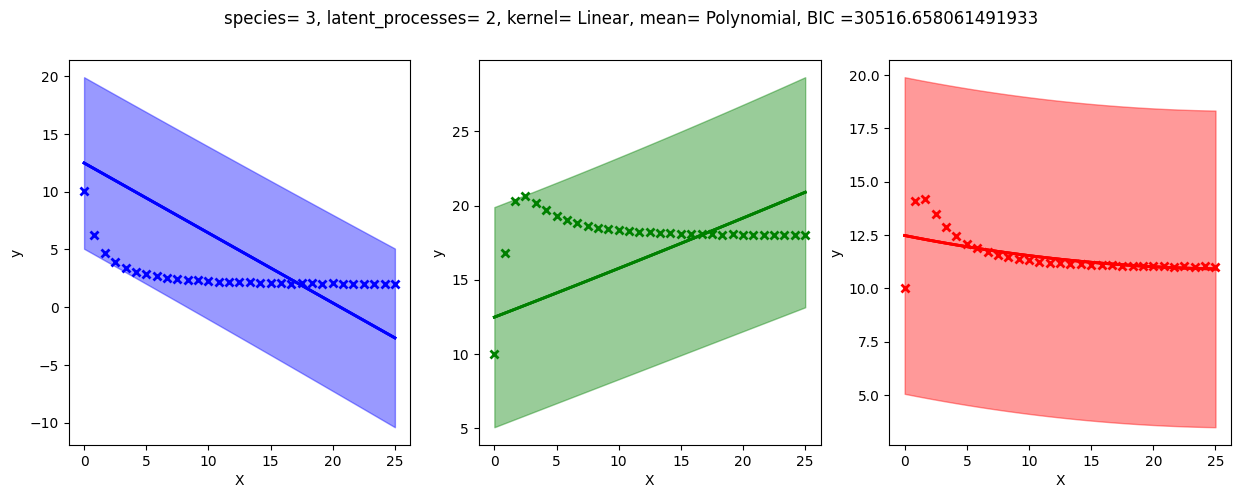

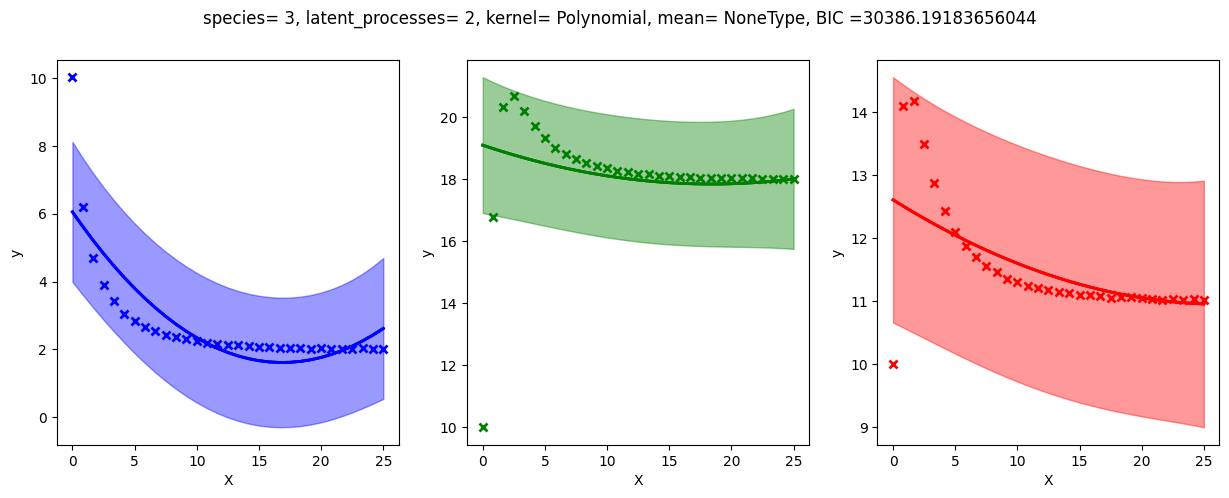

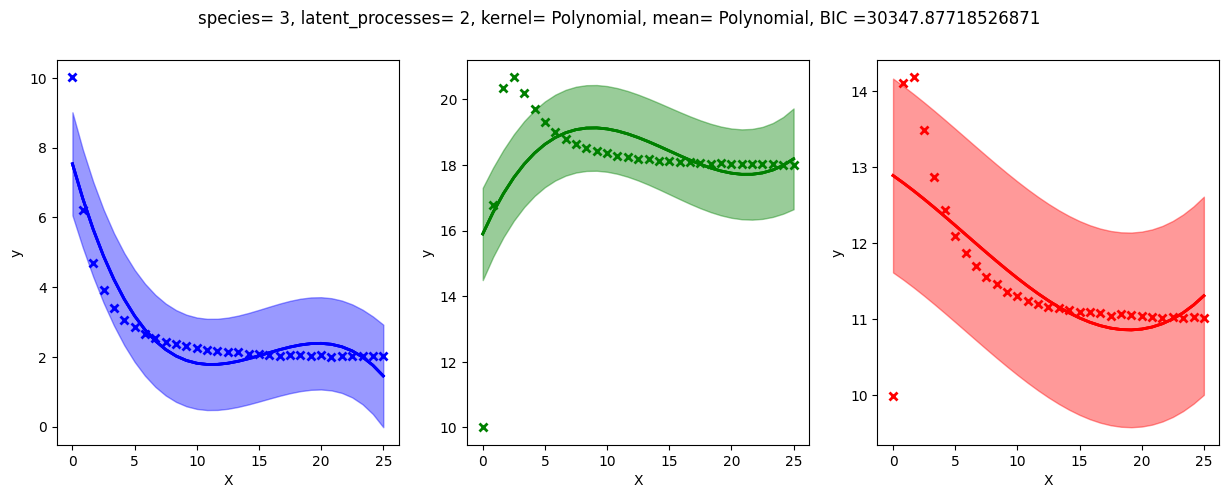

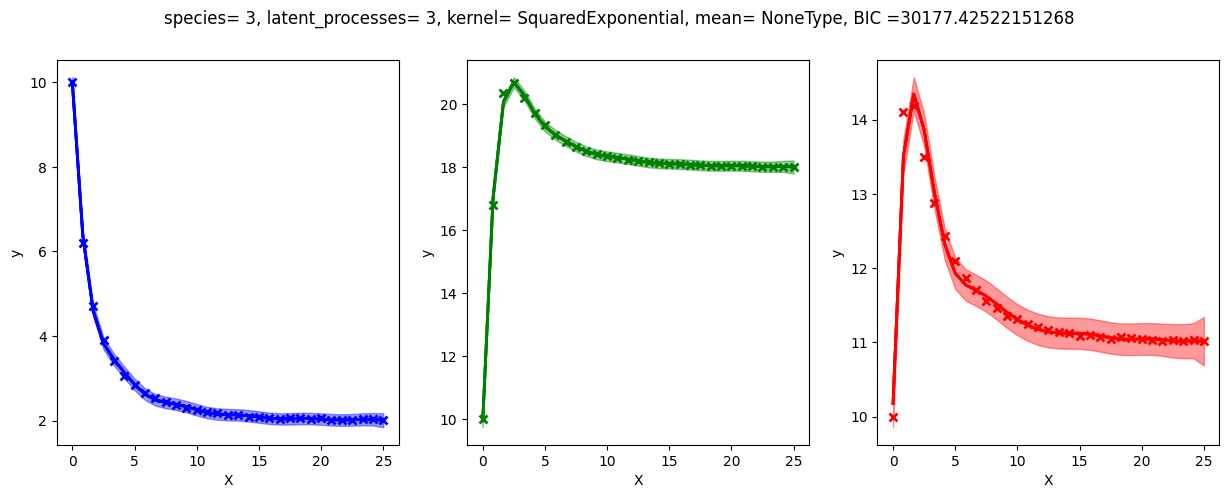

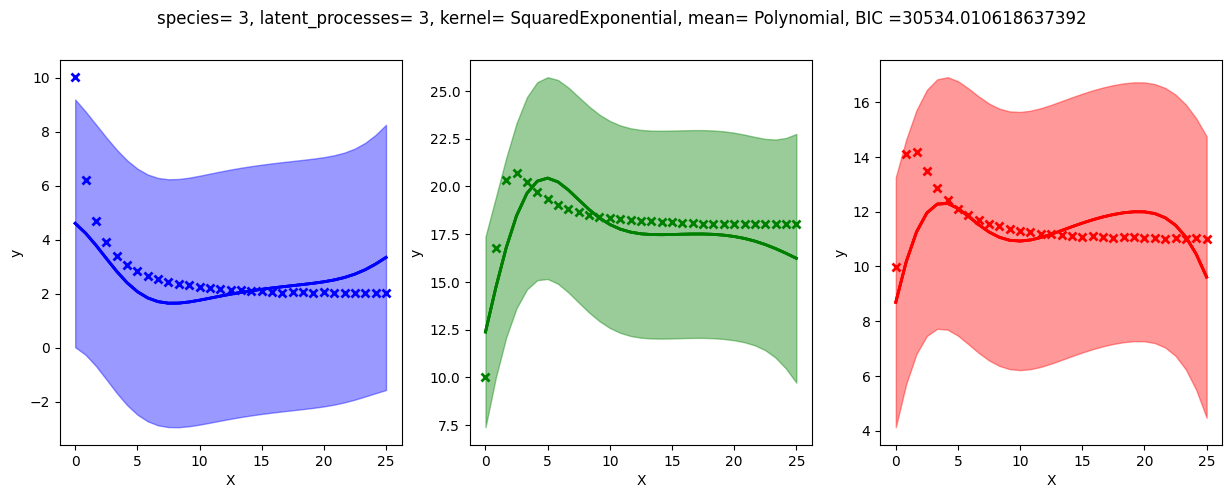

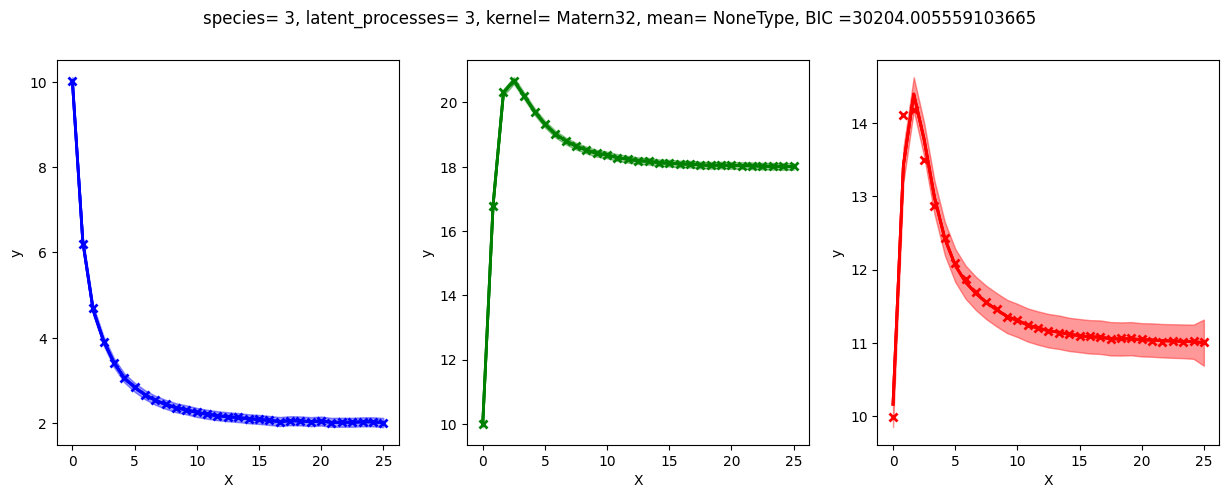

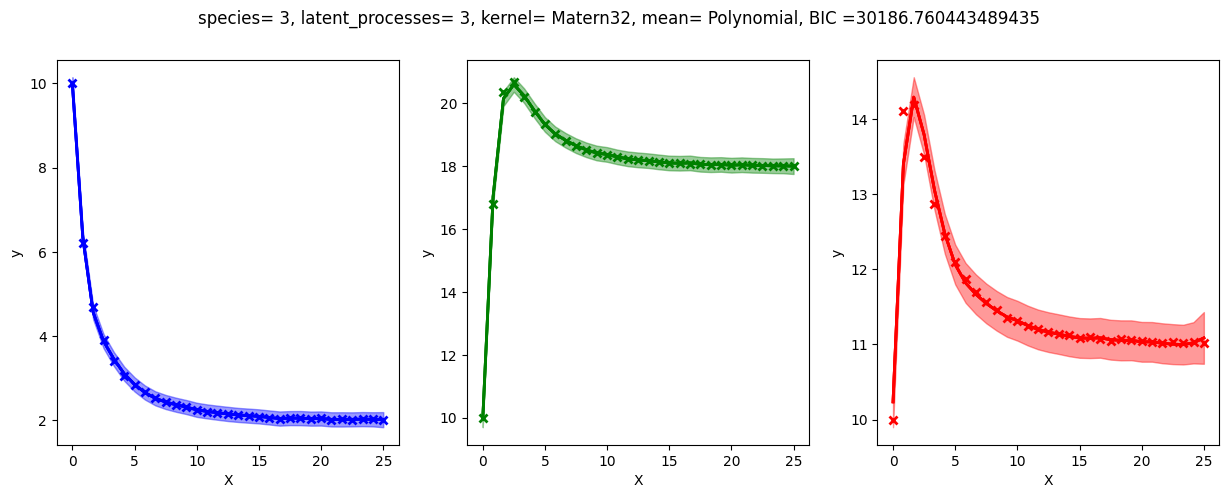

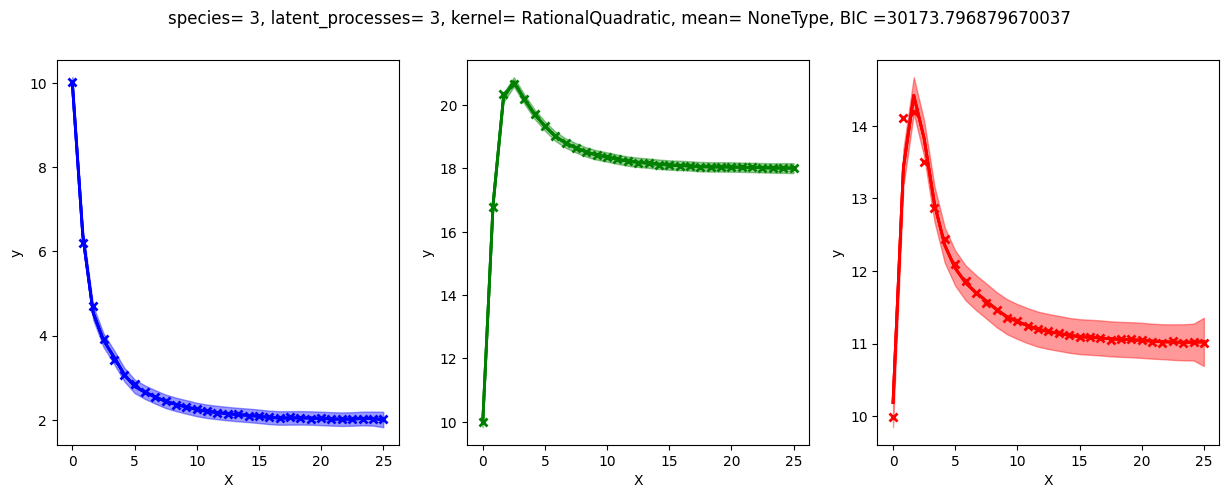

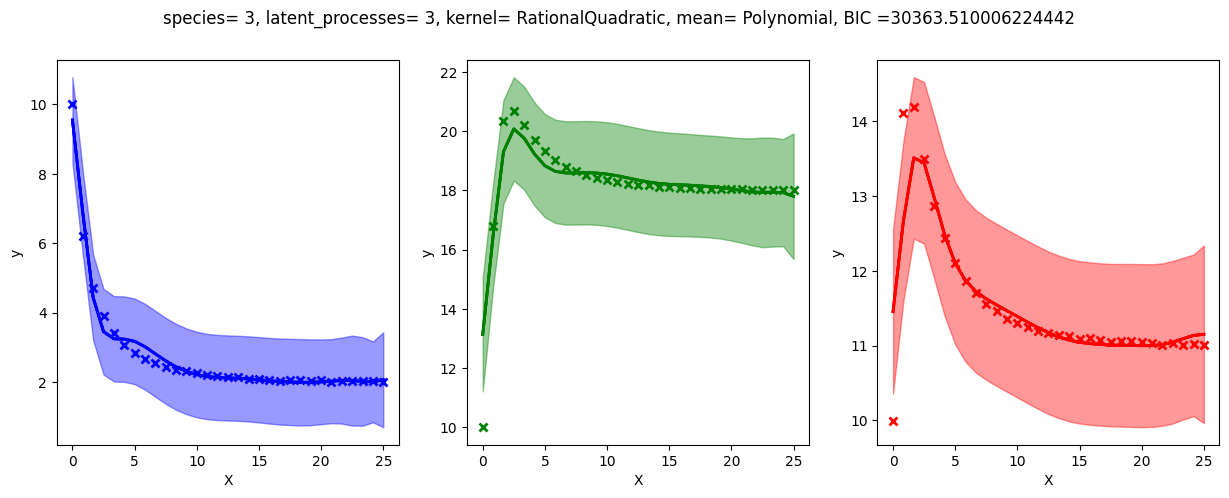

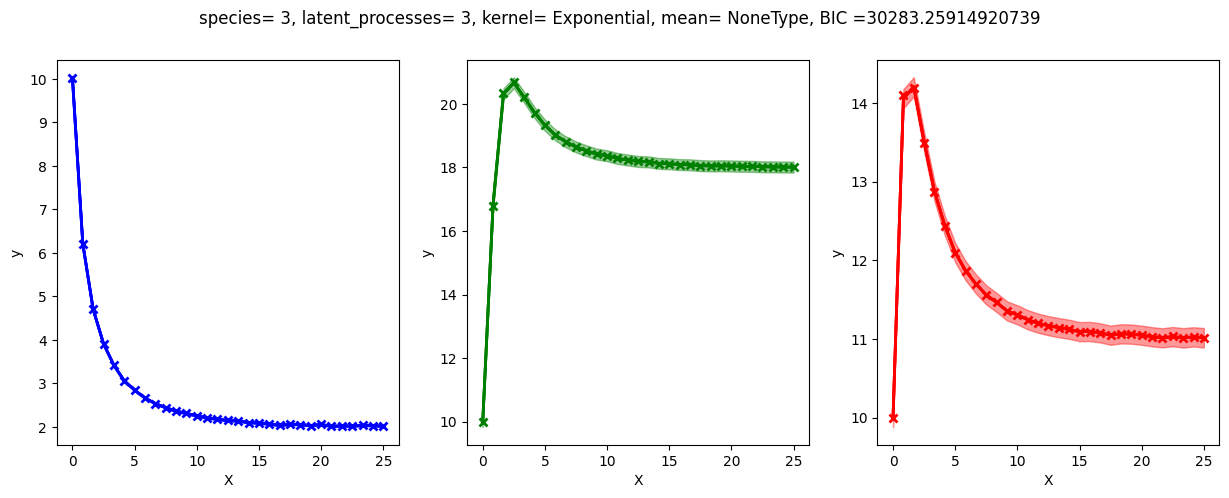

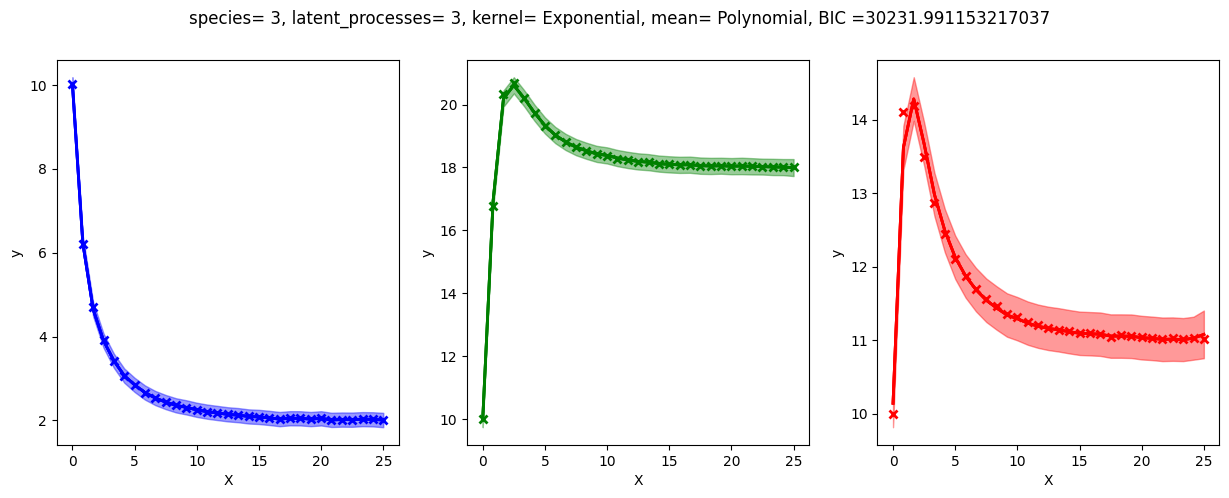

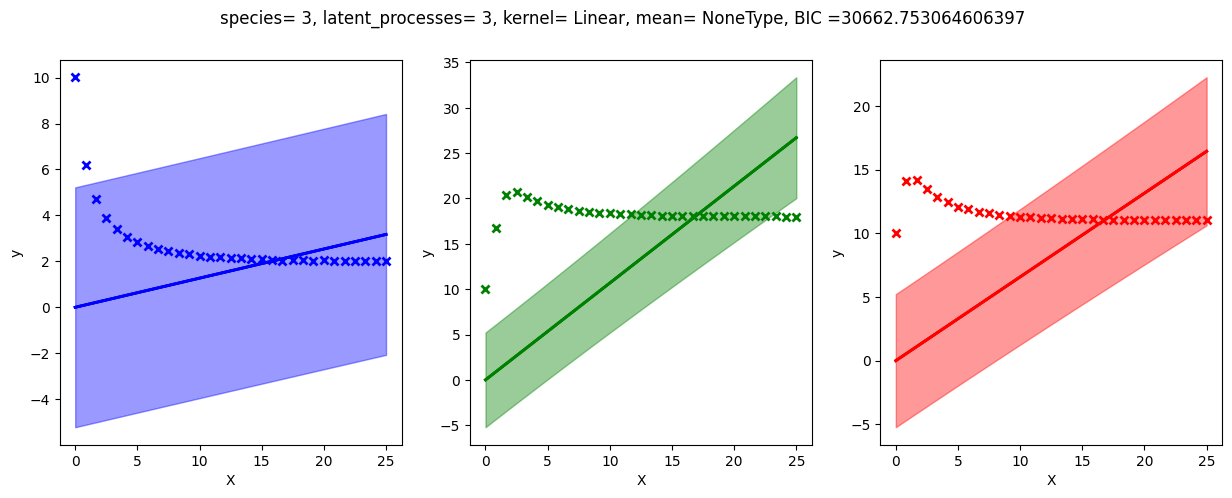

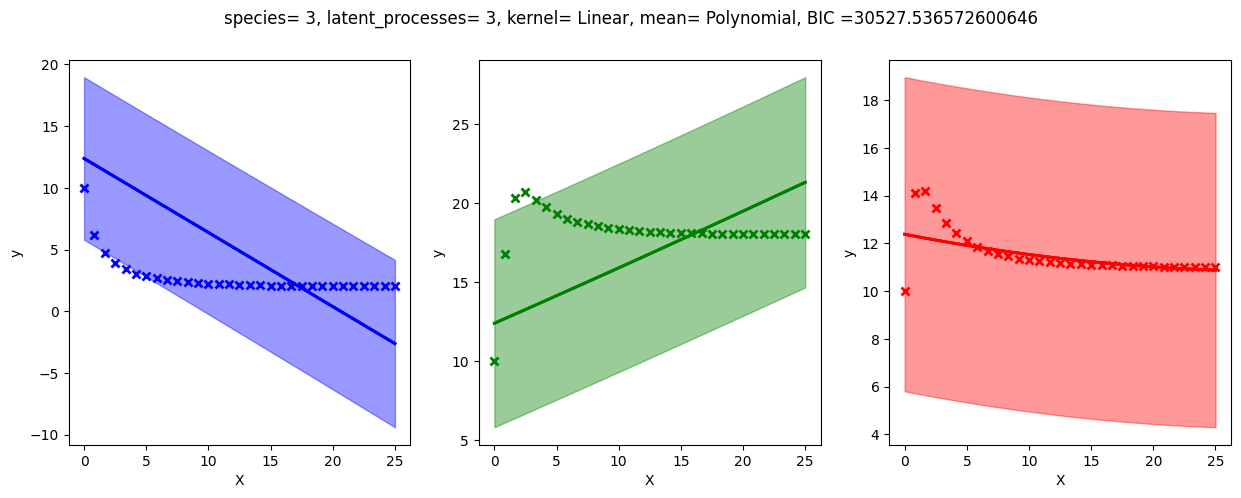

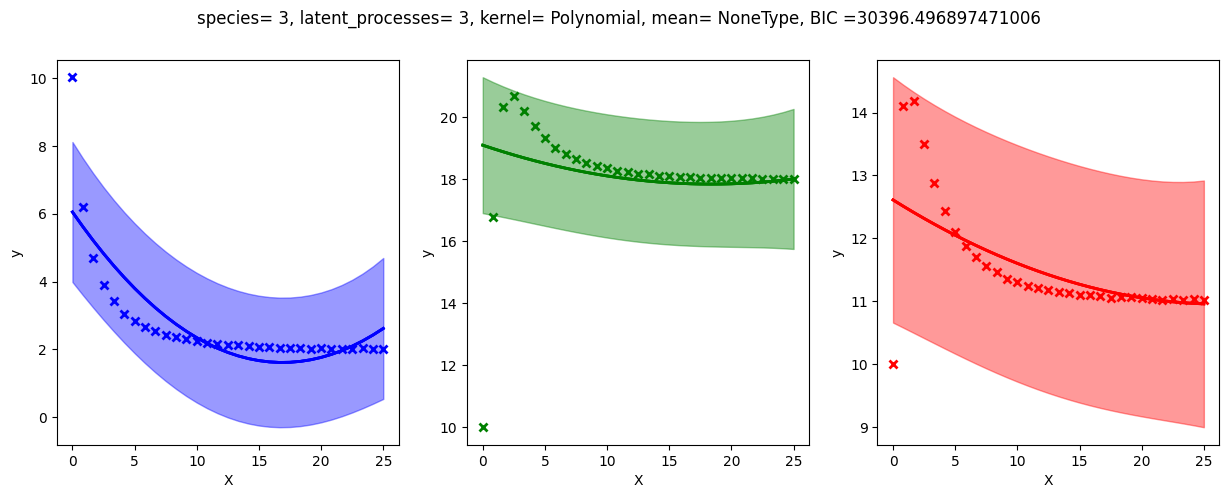

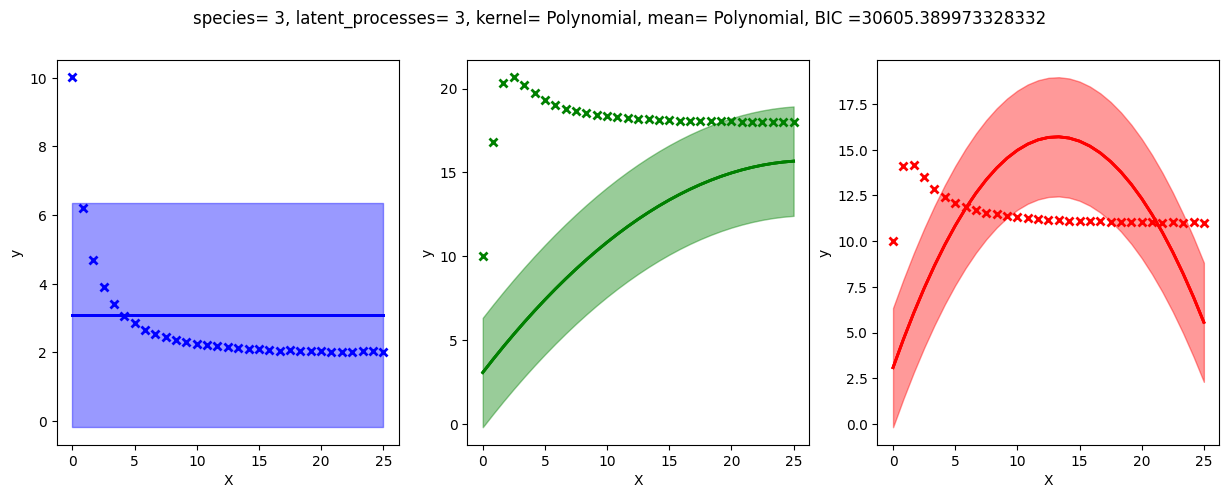

In [35]:
# Identifying the best kernel, mean function and latent process dimensionality for the data set using BIC score as the metric for comparison of models 

best_BIC = 10000000
kernels = [gpf.kernels.SquaredExponential, gpf.kernels.Matern32, gpf.kernels.RationalQuadratic, gpf.kernels.Exponential, gpf.kernels.Linear, gpf.kernels.Cosine, gpf.kernels.Periodic, gpf.kernels.Polynomial, gpf.kernels.Matern12, gpf.kernels.Matern52, gpf.kernels.White]
reduced_kernels = [gpf.kernels.SquaredExponential, gpf.kernels.Matern32, gpf.kernels.RationalQuadratic, gpf.kernels.Exponential, gpf.kernels.Linear, gpf.kernels.Polynomial]
for L in range(1,4):
    for K_L in reduced_kernels:
        for M_F in [None, gpf.functions.Polynomial(2)]:
            m, BIC = fit_model(X_aug, Y_aug, P=3, L=L, K_L=K_L, M_F=M_F)
            if BIC < best_BIC:
                best_model = m
                best_BIC = BIC
                best_L = L
                best_K_L = K_L
                best_M_F = M_F                

In [45]:
print(best_BIC)
print(best_L)
print(best_K_L.__name__)
print(best_M_F.__class__.__name__)
print_summary(best_model)
count_params(m)


30157.242397659647
1
SquaredExponential
NoneType


8763

In [15]:
# Trying different kernels

#also known as the rbf kernel
def gaussain_kernel(x, y, s, l):
    k = (s**2)*np.exp(-(np.subtract.outer(x,y)**2)/(2*l**2))
    return k


def anova_kernel(x, y, s, d):
    try:
        k = np.exp(-(np.subtract.outer(x,y)**2)*s)**d
        for i in range(1,x.shape[1]):
            k += np.exp(-(np.subtract.outer(x[:,i],y[:,i])**2)*s)**d
    except:
        k = np.exp(-(np.subtract.outer(x,y)**2)*s)**d
    return k

def wave_kernel(x, y, t, d):
    th = np.abs(np.subtract.outer(x,y))/t
    k = (1/(th+d))*np.sin(th)
    
    return k

# make the wave kernel a GPFlow kernel

class Wave(gpf.kernels.Kernel):
    def __init__(self, t, d, active_dims=None):
        super().__init__(active_dims=active_dims)
        self.t = gpf.Param(t, transform=gpf.transforms.positive)
        self.d = gpf.Param(d, transform=gpf.transforms.positive)

    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        th = np.abs(np.subtract.outer(X[:,0],X2[:,0]))/self.t
        k = (1/(th+self.d))*np.sin(th)
        return k

    def Kdiag(self, X):
        return np.diag(self.K(X))


class CustomAnovaKernel(gpf.kernels.Kernel):
    def __init__(self, scale=1.0, degree=1, **kwargs):
        super().__init__(**kwargs)
        self.scale = gpf.Parameter(scale, transform=gpf.utilities.positive())
        self.degree = gpf.Parameter(degree, transform=gpf.utilities.positive())

    def K(self, X, X2=None):
        """
        Compute the covariance matrix between X and X2 with the ANOVA kernel function.
        """
        if X2 is None:
            X2 = X

        # Initialize kernel with zeros
        k = tf.zeros((X.shape[0], X2.shape[0]), dtype=gpf.default_float())

        for i in range(X.shape[1]):
            # Distance for dimension i
            dist = tf.reshape(X[:, i] - X2[:, i], (-1, 1))
            dist_squared = tf.square(dist)

            # ANOVA kernel for dimension i
            k_i = tf.exp(-self.scale * dist_squared) ** self.degree

            # Add to total kernel
            k += k_i

        return k

    def K_diag(self, X):
        """
        Compute the diagonal of the covariance matrix of X with the ANOVA kernel function.
        """
        return tf.fill(tf.shape(X)[:-1], tf.squeeze(self.scale ** self.degree))



def log_kernel(x, y, d):
    k = - np.log(np.abs(np.subtract.outer(x,y))**d + 1)   
    return k

def cauchy_kernel(x, y, s):
    k = 1/(1+(np.subtract.outer(x,y))**2/s)   
    return k

def generalised_student_t_kernel(x, y, d):
    k = 1/(1+np.abs(np.subtract.outer(x,y))**d)   
    return k


In [16]:
# fit a GP model with latent process = 1 and mean function = None
# using the gaussian kernel, anova kernel, wave kernel, log kernel, cauchy kernel and generalised student t kernel

# m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=gaussain_kernel, M_F=None)
# m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=anova_kernel, M_F=None)
test = CustomAnovaKernel(scale=1.0, degree=2)
m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=CustomAnovaKernel(), M_F=None)
# m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=log_kernel, M_F=None)
# m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=cauchy_kernel, M_F=None)
# m, BIC = fit_model(X_aug, Y_aug, P=3, L=1, K_L=generalised_student_t_kernel, M_F=None)

# Identifying the best kernel, mean function and latent process dimensionality for the data set using BIC score as the metric for comparison of models

best_BIC = 10000000


TypeError: Error calling wrapped function (see above error). If you believe your parameters actually are correct, the error can sometimes be fixed by setting `tf_decorator=True` on your `@check_shapes` decorator.

In [ ]:
# Another scoring metric for model comparison is the log marginal likelihood of the model. The model with the highest log marginal likelihood is the best model.

## Wrap above code into a funtion
# P is the number of outputs (three in this case for the three species)
# L is the number of latent processes
# K_L is the kernel for the latent processes
# M_F is the mean function applied to latent processes

def fit_model(X_aug, Y_aug, P, L, K_L=gpf.kernels.SquaredExponential, M_F=None):
    
    # Base kernel for leatent processes
    #k = gpf.kernels.Matern32(active_dims=[0])
    #k = gpf.kernels.SquaredExponential(active_dims=[0])

    k = K_L(active_dims=[0])
    
    # Coregion kernel
    coreg = gpf.kernels.Coregion(
        output_dim=P, 
        rank=L, 
        active_dims=[1]
    )

    kern = k * coreg

    # This likelihood switches between Gaussian noise with different variances for each f_i:
    lik = gpf.likelihoods.SwitchedLikelihood(
        [gpf.likelihoods.Gaussian() for _ in range(P)]
    )

    # now build the GP model as normal
    # QUESTION: What is the difference between VGP and GPR?
    # ANSWER: VGP is variational Gaussian process regression. GPR is Gaussian process regression. VGP is used for large data sets. GPR is used for small data sets.
    # NOTE:https://gpflow.github.io/GPflow/develop/notebooks/getting_started/classification_and_other_data_distributions.html
    m = gpf.models.VGP((X_aug, Y_aug), kernel=kern, likelihood=lik, mean_function=M_F)

    # fit the covariance function parameters
    maxiter = reduce_in_tests(10000)
    res = gpf.optimizers.Scipy().minimize(
        m.training_loss,
        m.trainable_variables,
        options=dict(maxiter=maxiter),
        method="L-BFGS-B",
    )



    

    print_summary(m)
    BIC = get_BIC(m,res.fun,X.shape[0])
    print("BIC:", BIC)
    plot_model(m,X, P, L, K_L, M_F, BIC)

    return m, BIC



## Try different kernels
#k = gpf.kernels.Matern32(active_dims=[0])
#k = gpf.kernels.SquaredExponential(active_dims=[0])
#k = gpf.kernels.RationalQuadratic(active_dims=[0])
#k = gpf.kernels.Exponential(active_dims=[0])
#k = gpf.kernels.Linear(active_dims=[0])
#k = gpf.kernels.Cosine(active_dims=[0])
#k = gpf.kernels.Periodic(active_dims=[0])
#k = gpf.kernels.Polynomial(active_dims=[0])
#k = gpf.kernels.Matern12(active_dims=[0])
#k = gpf.kernels.Matern52(active_dims=[0])
#k = gpf.kernels.Brownian(active_dims=[0])
#k = gpf.kernels.White(active_dims=[0])
#k = gpf.kernels.Constant(active_dims=[0])
#k = gpf.kernels.Coregion(active_dims=[0])
#k = gpf.kernels.ChangePoints(active_dims=[0])
#k = gpf.kernels.LinearCoregionalization(active_dims=[0])
    

best_log_marginal_likelihood = -10000000
kernels = [gpf.kernels.SquaredExponential, gpf.kernels.Matern32, gpf.kernels.RationalQuadratic, gpf.kernels.Exponential, gpf.kernels.Linear, gpf.kernels.Cosine, gpf.kernels.Periodic, gpf.kernels.Polynomial, gpf.kernels.Matern12, gpf.kernels.Matern52, gpf.kernels.White]
reduced_kernels = [gpf.kernels.SquaredExponential, gpf.kernels.Matern32, gpf.kernels.RationalQuadratic, gpf.kernels.Exponential, gpf.kernels.Linear, gpf.kernels.Polynomial]
for L in range(1,4):
    for K_L in reduced_kernels:
        for M_F in [None, gpf.functions.Polynomial(2)]:
            m, log_marginal_likelihood = fit_model(X_aug, Y_aug, P=3, L=L, K_L=K_L, M_F=M_F)
            if log_marginal_likelihood > best_log_marginal_likelihood:
                best_model = m
                best_log_marginal_likelihood = log_marginal_likelihood
                best_L = L
                best_K_L = K_L
                best_M_F = M_F

print(best_log_marginal_likelihood)
print(best_L)
print(best_K_L)
print(best_M_F)
print(best_model)
